In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0.dev0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.io import ascii
from astropy import units as u
from astropy import constants

deg = np.pi/180.
yr = 365.25 # days / year

# Astrometric Orbits with Exoplanet

In the previous tutorial (:ref:`astrometric`) we showed how to fit an orbit with `exoplanet` where only astrometric information is available. In this notebook we'll extend that same example to also include the available radial velocity information on the system. 

## Data 
As before we'll use the astrometric and radial velocity measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract), and the radial velocities  are from [Tokovinin 1993](https://ui.adsabs.harvard.edu/#abs/1993AstL...19...73T/abstract). 

In [4]:
# grab the formatted data and do some munging

dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

rv1_data = ascii.read(dirname + "rv1.txt", format="csv")
rv2_data = ascii.read(dirname + "rv2.txt", format="csv")

In [5]:
# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask) # eliminate entries with no measurements

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

# adjust the errors as before
astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# the position angle measurements come in degrees in the range [0, 360].
# we need to convert this to radians in the range [-pi, pi]
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

In [6]:
# take out the data as only numpy arrays
rv1 = rv1_data["rv"].data
rv1_err = rv1_data["err"].data

rv2 = rv2_data["rv"].data
rv2_err = rv2_data["err"].data

# adapt the dates of the RV series 
rv1_dates = Time(rv1_data["date"] + 2400000, format="jd")
rv1_jds = rv1_dates.value
rv2_dates = Time(rv2_data["date"] + 2400000, format="jd")
rv2_jds = rv2_dates.value

rv1_yr = rv1_dates.decimalyear
rv2_yr = rv2_dates.decimalyear

As before, we'll plot $\rho$ vs. time and P.A. vs. time. We'll also add the RV time series for the primary and secondary stars.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


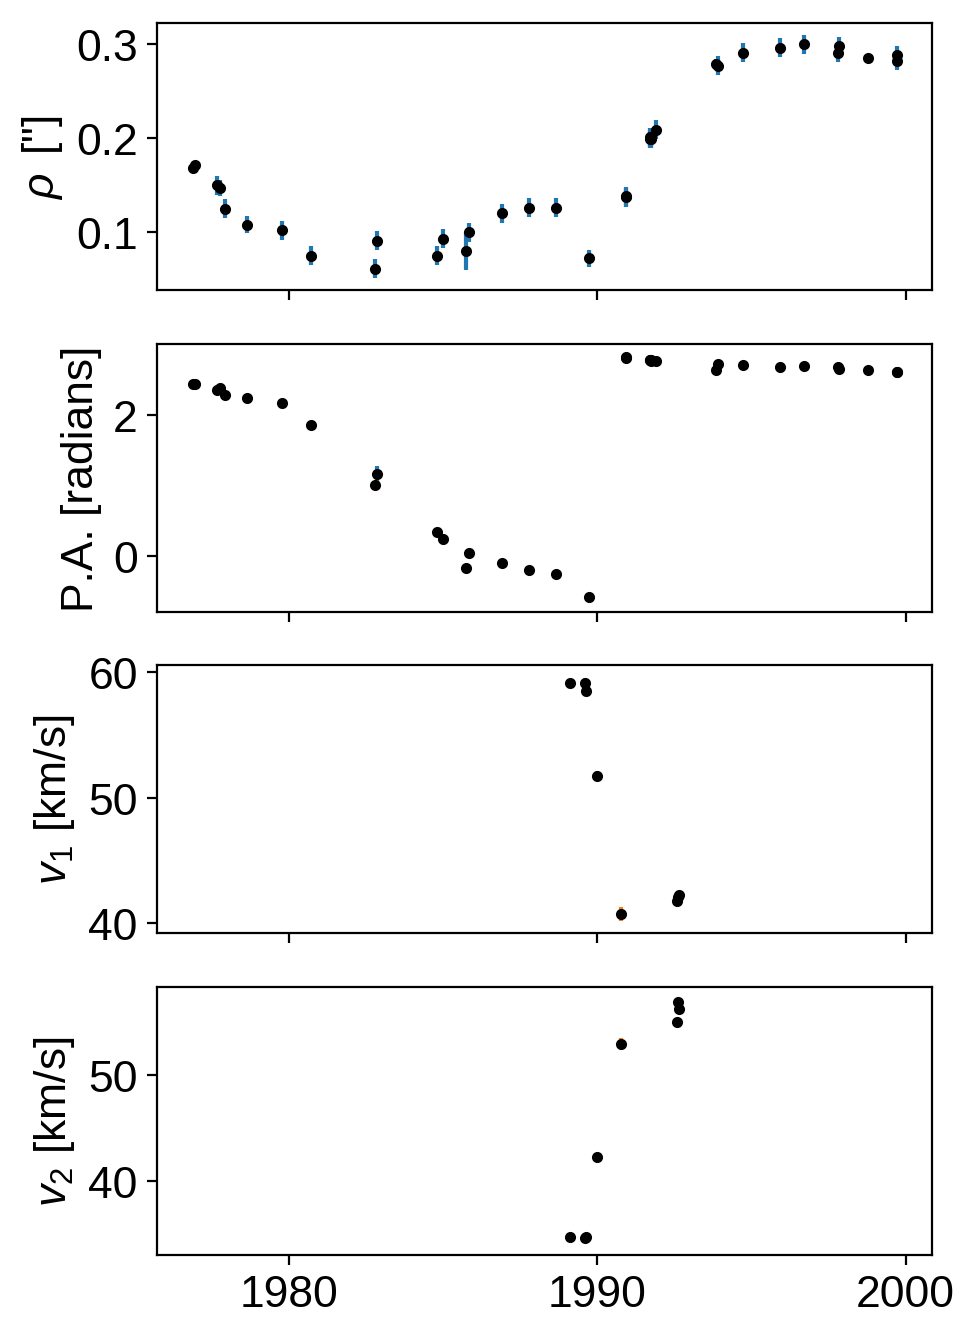

In [7]:
pkw = {"ls":"", "color":"k", "marker":"."}
ekw = {"ls":"", "color":"C1"}

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(astro_yrs, rho_data, **pkw)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, ls="")
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(astro_yrs, theta_data, **pkw)
ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, ls="")
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(rv1_yr, rv1, **pkw)
ax[2].errorbar(rv1_yr, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(rv2_yr, rv2, **pkw)
ax[3].errorbar(rv2_yr, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

In [8]:
# import the relevant packages 
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
import exoplanet.orbits
from exoplanet.distributions import Angle

First, let's plot up a basic orbit with *exoplanet* to see if the best-fit parameters from Pourbaix et al. make sense. With the addition of radial velocity data, we can now constrain the masses of the stars. 

In [9]:
def calc_Mtot(a, P):
    '''
    Calculate the total mass of the system using Kepler's third law. 
    
    Args: 
        a (au) semi-major axis
        P (days) period 
        
    Returns:
        Mtot (M_sun) total mass of system (M_primary + M_secondary)
    '''
    
    day_to_s = (1 * u.day).to(u.s).value
    au_to_m = (1 * u.au).to(u.m).value
    kg_to_M_sun = (1 * u.kg).to(u.M_sun).value
    
    return 4 * np.pi**2 * (a * au_to_m)**3 / (constants.G.value * (P * day_to_s)**2) * kg_to_M_sun

In [10]:
# Orbital elements from Pourbaix et al. 1998

# conversion constant
au_to_km = constants.au.to(u.km).value
au_to_R_sun = (constants.au / constants.R_sun).value

a_ang = 0.324 # arcsec
mparallax = 27.0 # milliarcsec 
parallax = 1e-3 * mparallax
a = a_ang / parallax # au

e = 0.798
i = 96.0 * deg # [rad]
omega = 251.6 * deg - np.pi # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * yr # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value # [Julian Date]

gamma = 47.8 # km/s; systemic velocity

# kappa = a1 / (a1 + a2)
kappa = 0.45 

# we parameterize exoplanet in terms of M2, so we'll need to 
# calculate Mtot from a, P, then M2 from Mtot and kappa
Mtot = calc_Mtot(a, P)
M2 = kappa * Mtot


# n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
# note that we now include M2 in the KeplerianOrbit initialization
orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=T0, period=P, 
                               incl=i, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

# make a theano function to get stuff from orbit 
times = tt.vector("times")
ang = orbit.get_relative_angles(times, parallax) # the rho, theta measurements

# convert from R_sun / day to km/s
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value
    
rv1_model = conv * orbit.get_star_velocity(times)[2] + gamma
rv2_model = conv * orbit.get_planet_velocity(times)[2] + gamma

f_ang = theano.function([times], ang)
f_rv1 = theano.function([times], rv1_model)
f_rv2 = theano.function([times], rv2_model)

t = np.linspace(T0 - 0.5 * P, T0 + 0.5 * P, num=2000) # days

rho_model, theta_model = f_ang(t)

rv1s = f_rv1(t)
rv2s = f_rv2(t)

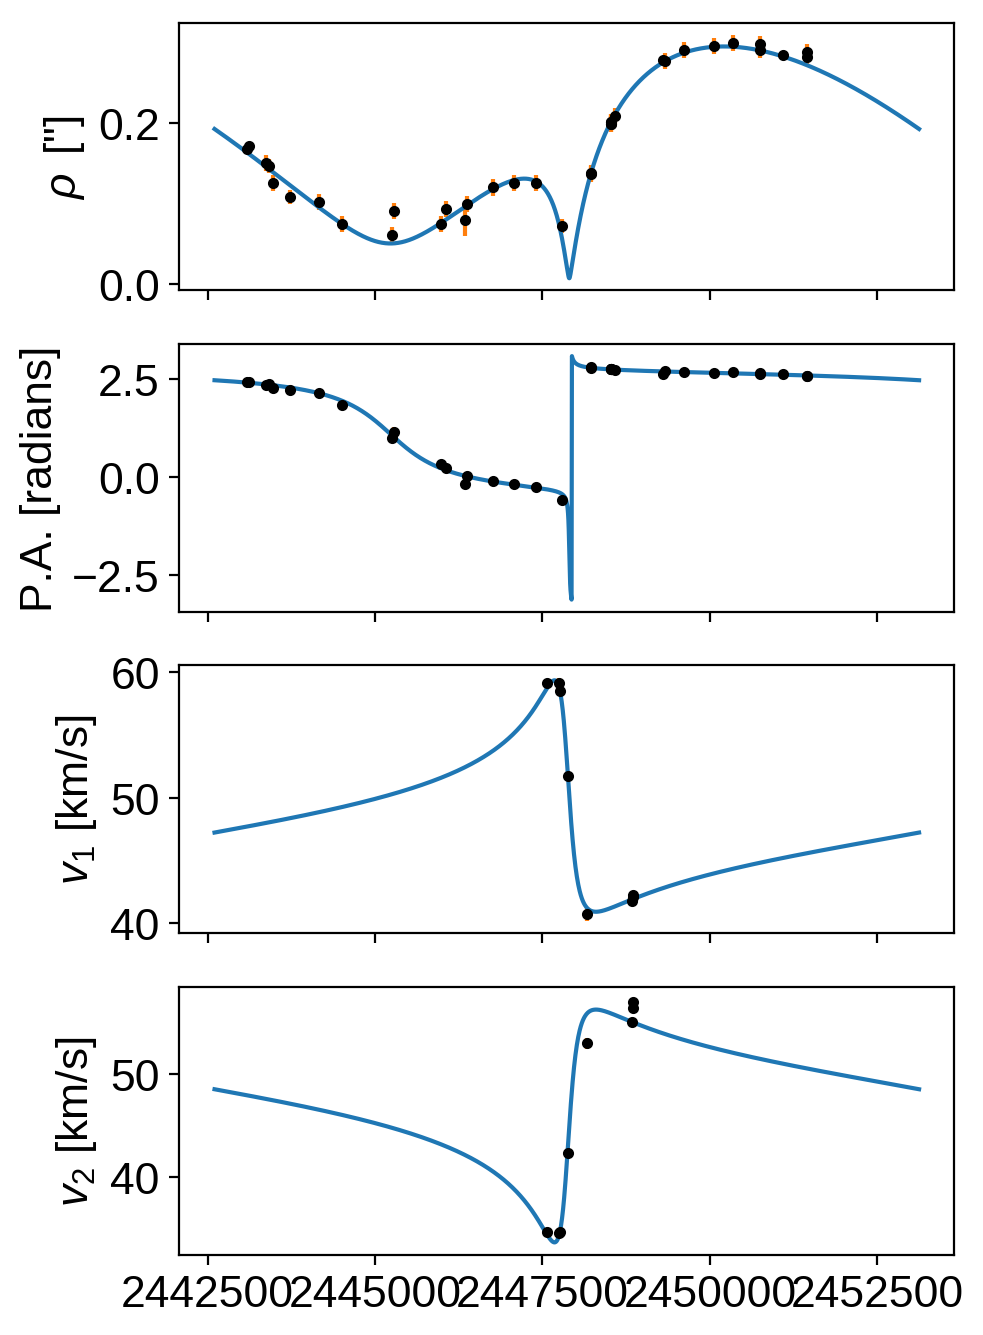

In [11]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
ax[0].plot(t, rho_model)
ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].plot(t, theta_model)
ax[1].plot(astro_jds, theta_data, **pkw)
ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
ax[1].set_ylabel(r'P.A. [radians]');

ax[2].plot(t, rv1s)
ax[2].plot(rv1_jds, rv1, **pkw)
ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
ax[2].set_ylabel(r"$v_1$ [km/s]")

ax[3].plot(t, rv2s)
ax[3].plot(rv2_jds, rv2, **pkw)
ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
ax[3].set_ylabel(r"$v_2$ [km/s]");

It looks like a pretty good starting point. So, let's set up the model in PyMC3 for sampling.

In [12]:
# convert from R_sun / day to km/s
# and from v_r = - v_Z
output_units = u.km / u.s
conv = -(1 * u.R_sun / u.day).to(output_units).value

# for theta wrapping 
zeros = np.zeros_like(astro_jds)

# for predicted orbits
t_fine = np.linspace(astro_jds.min(), astro_jds.max(), num=1000)
rv_times = np.linspace(rv1_jds.min(), rv1_jds.max(), num=1000)

# for predicted sky orbits, spanning a full period
t_sky = np.linspace(0, 1, num=500)

with pm.Model() as model:

    # We'll include the parallax data as a prior on the parallax value     
    mparallax = pm.Normal("mparallax", mu=24.05, sd=0.45) # milliarcsec GAIA DR2
    parallax = pm.Deterministic("parallax", 1e-3 * mparallax) # arcsec
    a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324) # arcsec 
        
    # the semi-major axis in au
    a = pm.Deterministic("a", a_ang / parallax)
        
    # we expect the period to be somewhere in the range of 25 years, 
    # so we'll set a broad prior on logP
    logP = pm.Uniform("logP", lower=np.log(1 * yr), upper=np.log(100* yr), testval=np.log(28.8 * yr))
    P = pm.Deterministic("P", tt.exp(logP)) # days
    
    # Since we're doing an RV + astrometric fit, M2 now becomes a parameter of the model
    M2 = pm.Normal("M2", mu=1.0, sd=0.5) # solar masses
    
    gamma = pm.Normal("gamma", mu=47.8, sd=5.0) # km/s
    
    omega = Angle("omega", testval=251.6 * deg - np.pi) # - pi to pi
    Omega = Angle("Omega", testval=159.6 * deg) # - pi to pi
    
    t_periastron = pm.Uniform("tperi", T0 - P, T0 + P)
    
    # uniform on cos incl
    cos_incl = pm.Uniform("cosIncl", lower=-1.0, upper=1.0, testval=np.cos(96.0 * deg)) # radians, 0 to 180 degrees
    incl = pm.Deterministic("incl", tt.arccos(cos_incl))
    
    e = pm.Uniform("e", lower=0.0, upper=1.0, testval=0.798)
           
    # n.b. that we include an extra conversion for a, because exoplanet expects a in R_sun
    orbit = xo.orbits.KeplerianOrbit(a=a * au_to_R_sun, t_periastron=t_periastron, period=P, 
                                   incl=incl, ecc=e, omega=omega, Omega=Omega, m_planet=M2)

    # now that we have a physical scale defined, the total mass of the system makes sense
    Mtot = pm.Deterministic("Mtot", orbit.m_total)
    M1 = pm.Deterministic("M1", Mtot - M2)
    
    # get the astrometric predictions
    rho_model, theta_model = orbit.get_relative_angles(astro_jds, parallax) # the rho, theta model values
        
    # add jitter terms to both separation and position angle
    log_rho_s = pm.Normal("logRhoS", mu=np.log(np.median(rho_err)), sd=5.0)
    log_theta_s = pm.Normal("logThetaS", mu=np.log(np.median(theta_err)), sd=5.0)
    
    rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
    theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))
    
    # evaluate the astrometric likelihood functions
    pm.Normal("obs_rho", mu=rho_model, observed=rho_data, sd=rho_tot_err)
    theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
    pm.Normal("obs_theta", mu=theta_diff, observed=zeros, sd=theta_tot_err)

    # get the radial velocity predictions    
    # get_star_velocity and get_planet_velocity return (v_x, v_y, v_z) tuples, so we only need the v_z vector
    # but, note that since +Z points towards the observer, we actually want v_radial = -v_Z (see conv)
    # this is handled naturally by exoplanets get_radial_velocity (of the star), but since we also want
    # the "planet" velocity, or the velocity of the secondary, we queried both in this manner to be consistent
    rv1_model = conv * orbit.get_star_velocity(rv1_jds)[2] + gamma
    rv2_model = conv * orbit.get_planet_velocity(rv2_jds)[2] + gamma
    
    log_rv1_s = pm.Normal("logRV1S", mu=np.log(np.median(rv1_err)), sd=5.0)
    log_rv2_s = pm.Normal("logRV2S", mu=np.log(np.median(rv2_err)), sd=5.0)
    
    rv1_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv1_s))
    rv2_tot_err = tt.sqrt(rv1_err**2 + tt.exp(2 * log_rv2_s))
    
    pm.Normal("obs_rv1", mu=rv1, observed=rv1_model, sd=rv1_tot_err)
    pm.Normal("obs_rv2", mu=rv2, observed=rv2_model, sd=rv2_tot_err)
    
    # save for future sep, pa, and RV plots 
    rho_dense, theta_dense = orbit.get_relative_angles(t_fine, parallax)
    rho_save = pm.Deterministic("rhoSave", rho_dense)
    theta_save = pm.Deterministic("thetaSave", theta_dense)    
    
    rv1_dense = pm.Deterministic("rv1Save", conv * orbit.get_star_velocity(rv_times)[2] + gamma)
    rv2_dense = pm.Deterministic("rv2Save", conv * orbit.get_planet_velocity(rv_times)[2] + gamma)
    
    # sky plots
    t_period = pm.Deterministic("tPeriod", t_sky * P + t_periastron)
    
    # save some samples on a fine orbit for sky plotting purposes
    rho, theta = orbit.get_relative_angles(t_period, parallax)
    rho_save_sky = pm.Deterministic("rhoSaveSky", rho)
    theta_save_sky = pm.Deterministic("thetaSaveSky", theta)

In [13]:
with model:
    map_sol = xo.optimize()

optimizing logp for variables: ['logRV2S', 'logRV1S', 'logThetaS', 'logRhoS', 'e_interval__', 'cosIncl_interval__', 'tperi_interval__', 'Omega_angle__', 'omega_angle__', 'gamma', 'M2', 'logP_interval__', 'a_ang_interval__', 'mparallax']


message: Optimization terminated successfully.
logp: -181.756334838994 -> 171.06970010730305


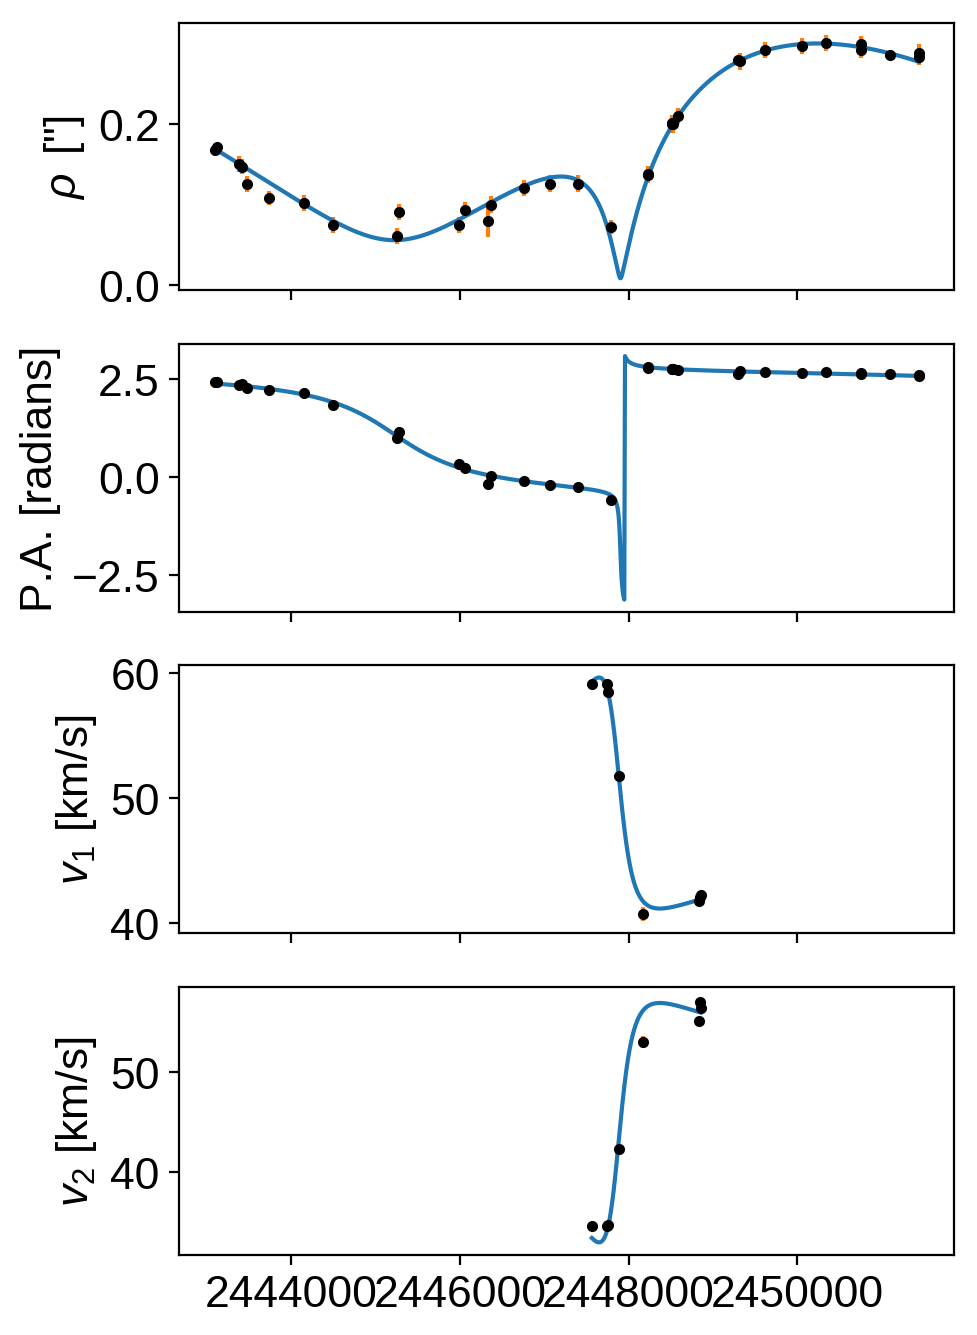

In [14]:
with model:

    fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(5,8))
    ax[0].plot(t_fine, xo.eval_in_model(rho_save, map_sol))
    ax[0].plot(astro_jds, rho_data, **pkw)
    ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, **ekw)
    ax[0].set_ylabel(r'$\rho\,$ ["]')

    ax[1].plot(t_fine, xo.eval_in_model(theta_save, map_sol))
    ax[1].plot(astro_jds, theta_data, **pkw)
    ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, **ekw)
    ax[1].set_ylabel(r'P.A. [radians]');

    ax[2].plot(rv_times, xo.eval_in_model(rv1_dense, map_sol))
    ax[2].plot(rv1_jds, rv1, **pkw)
    ax[2].errorbar(rv1_jds, rv1, yerr=rv1_err, **ekw)
    ax[2].set_ylabel(r"$v_1$ [km/s]")

    ax[3].plot(rv_times, xo.eval_in_model(rv2_dense, map_sol))
    ax[3].plot(rv2_jds, rv2, **pkw)
    ax[3].errorbar(rv2_jds, rv2, yerr=rv2_err, **ekw)
    ax[3].set_ylabel(r"$v_2$ [km/s]");

In [15]:
# now let's actually explore the posterior for real
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=4000, start=map_sol,
                          step_kwargs=dict(target_accept=0.95))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:00<00:08, 96.98draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:00<00:12, 64.00draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:15, 51.98draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:00<00:16, 46.96draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:17, 44.01draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:00<00:18, 42.16draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:18, 40.94draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:00<00:19, 40.12draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:19, 39.58draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:01<00:19, 39.20draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:01<00:19, 38.96draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:19, 38.80draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:01<00:19, 38.68draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:01<00:19, 38.60draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:01<00:19, 38.54draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:20, 36.68draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:01<00:19, 36.82draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:19, 36.95draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:02<00:19, 37.03draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:02<00:19, 37.10draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:02<00:19, 37.16draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:02<00:19, 37.20draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:02<00:18, 37.22draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:18, 37.24draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:02<00:18, 37.27draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:02<00:18, 37.28draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:02<00:18, 37.28draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:03<00:18, 37.29draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:18, 37.28draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:03<00:18, 37.30draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:03<00:18, 37.30draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:03<00:17, 37.31draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:03<00:17, 37.31draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:03<00:17, 37.31draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:03<00:18, 35.78draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:03<00:18, 36.06draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:03<00:16, 38.92draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:04<00:16, 38.25draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:04<00:16, 38.02draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:04<00:16, 37.86draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:04<00:16, 37.74draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:04<00:17, 36.86draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:04<00:15, 39.35draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:04<00:16, 38.73draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:04<00:16, 38.32draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:04<00:16, 38.04draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:05<00:16, 37.83draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:05<00:16, 37.24draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:05<00:16, 37.29draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:05<00:15, 37.34draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:05<00:15, 37.36draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:05<00:15, 37.37draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:05<00:16, 35.81draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:05<00:16, 36.27draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:05<00:15, 36.18draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:06<00:15, 36.53draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:06<00:15, 36.78draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:06<00:15, 36.79draws/s]

Sampling 4 chains:  31%|███       | 247/808 [00:06<00:15, 36.95draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:06<00:15, 37.08draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:06<00:14, 37.17draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:06<00:14, 37.30draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:06<00:14, 37.52draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:06<00:14, 36.96draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:07<00:14, 37.29draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:07<00:14, 37.55draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:07<00:14, 37.74draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:07<00:13, 37.89draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:07<00:13, 37.99draws/s]

Sampling 4 chains:  36%|███▌      | 291/808 [00:07<00:13, 38.06draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:07<00:13, 38.10draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:07<00:13, 37.53draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:13, 37.16draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:07<00:13, 37.48draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:08<00:13, 37.72draws/s]

Sampling 4 chains:  39%|███▉      | 315/808 [00:08<00:13, 37.89draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:08<00:12, 38.01draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:08<00:12, 38.08draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:08<00:12, 38.15draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:08<00:12, 37.07draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:08<00:12, 37.08draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:08<00:12, 37.12draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:08<00:12, 37.11draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:09<00:12, 37.12draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:09<00:12, 37.16draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:09<00:12, 37.17draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:09<00:12, 37.20draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:09<00:11, 37.23draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:09<00:11, 37.00draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:09<00:11, 37.06draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:09<00:11, 37.14draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:09<00:11, 37.16draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:10<00:11, 37.20draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:10<00:11, 37.23draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:10<00:11, 37.24draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:10<00:11, 36.95draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:10<00:11, 37.07draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:10<00:10, 37.16draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:10<00:10, 37.22draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:10<00:11, 35.34draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:10<00:10, 35.91draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:11<00:10, 36.35draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:11<00:10, 36.65draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:11<00:10, 36.88draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:11<00:10, 37.05draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:11<00:10, 37.18draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:11<00:09, 37.26draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:11<00:09, 37.31draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:11<00:09, 37.34draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:11<00:09, 37.36draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:11<00:09, 37.33draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:12<00:09, 37.36draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [00:12<00:09, 37.56draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [00:12<00:09, 37.84draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:12<00:08, 38.02draws/s]

Sampling 4 chains:  59%|█████▉    | 475/808 [00:12<00:08, 38.18draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:12<00:08, 38.27draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [00:12<00:08, 38.35draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:12<00:08, 38.39draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:12<00:08, 38.43draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:13<00:08, 37.95draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:13<00:08, 38.11draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:13<00:07, 38.23draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:13<00:07, 38.31draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:13<00:07, 38.38draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:13<00:07, 38.22draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:13<00:07, 38.30draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:13<00:07, 38.35draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:13<00:07, 38.39draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:13<00:07, 38.41draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:14<00:07, 38.44draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:14<00:07, 37.70draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:14<00:06, 38.33draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:14<00:06, 38.18draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:14<00:06, 38.19draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [00:14<00:06, 37.95draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [00:14<00:06, 37.81draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:14<00:06, 37.73draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:14<00:06, 37.66draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:15<00:06, 37.61draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:15<00:06, 37.59draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:15<00:06, 37.58draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:15<00:05, 37.55draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:15<00:05, 37.54draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:15<00:05, 37.54draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:15<00:05, 37.48draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:15<00:05, 37.49draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:15<00:05, 37.50draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:15<00:05, 37.50draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:16<00:05, 37.50draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:16<00:05, 37.51draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:16<00:05, 37.52draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:16<00:04, 37.51draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:16<00:04, 37.51draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:16<00:04, 37.51draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:16<00:04, 37.51draws/s]

Sampling 4 chains:  79%|███████▉  | 639/808 [00:16<00:04, 37.52draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:16<00:04, 37.52draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:17<00:04, 37.50draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:17<00:04, 37.51draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:17<00:04, 37.52draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [00:17<00:03, 37.52draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:17<00:03, 37.53draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:17<00:03, 37.53draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:17<00:03, 37.52draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:17<00:03, 37.52draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:17<00:03, 37.53draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:17<00:03, 37.51draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:18<00:03, 38.12draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:18<00:03, 38.24draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [00:18<00:02, 38.30draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:18<00:02, 38.34draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:18<00:02, 40.82draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [00:18<00:02, 38.14draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:18<00:02, 37.99draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:18<00:02, 37.87draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:19<00:02, 37.80draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:19<00:02, 37.74draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:19<00:02, 37.65draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:19<00:01, 40.05draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [00:19<00:01, 38.01draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:19<00:01, 38.15draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:19<00:01, 38.25draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:19<00:01, 38.32draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:19<00:01, 38.37draws/s]

Sampling 4 chains:  94%|█████████▍| 760/808 [00:19<00:01, 38.38draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:20<00:01, 38.40draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:20<00:01, 38.44draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [00:20<00:00, 38.44draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:20<00:00, 38.46draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:20<00:00, 38.46draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:20<00:00, 38.46draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [00:20<00:00, 38.09draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [00:20<00:00, 33.23draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:21<00:00, 33.06draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:21<00:00, 32.06draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:21<00:00, 19.32draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:21<00:00, 12.28draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:22<00:00, 36.72draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▍         | 17/408 [00:00<00:03, 114.48draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 66.78draws/s] 

Sampling 4 chains:   6%|▋         | 26/408 [00:00<00:06, 57.56draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:00<00:07, 49.25draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:08, 44.76draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:00<00:08, 45.13draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:00<00:07, 46.62draws/s]

Sampling 4 chains:  12%|█▏        | 50/408 [00:00<00:08, 44.40draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:01<00:08, 42.33draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:01<00:07, 45.54draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:01<00:07, 43.68draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:01<00:08, 41.95draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:07, 42.39draws/s]

Sampling 4 chains:  20%|█▉        | 81/408 [00:01<00:07, 43.42draws/s]

Sampling 4 chains:  21%|██        | 86/408 [00:01<00:07, 44.21draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:01<00:07, 44.52draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:07, 42.24draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:02<00:07, 41.85draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:02<00:07, 39.79draws/s]

Sampling 4 chains:  27%|██▋       | 111/408 [00:02<00:07, 40.63draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:06, 44.16draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:02<00:06, 43.47draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:02<00:06, 43.48draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:02<00:06, 43.97draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:02<00:06, 44.68draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:03<00:06, 43.94draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:03<00:06, 43.20draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:03<00:05, 44.21draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:03<00:06, 38.47draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:03<00:06, 38.00draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:03<00:05, 41.96draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:03<00:05, 42.19draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:03<00:05, 41.36draws/s]

Sampling 4 chains:  45%|████▍     | 183/408 [00:04<00:05, 42.16draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:04<00:05, 43.42draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:04<00:04, 43.76draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:04<00:04, 42.70draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:04<00:04, 43.21draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:04<00:04, 46.38draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:04<00:04, 41.00draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:04<00:04, 40.72draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:05<00:04, 41.62draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:05<00:04, 38.48draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:05<00:04, 38.01draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:05<00:04, 40.17draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:05<00:03, 41.83draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:05<00:03, 43.07draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:05<00:03, 43.35draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:05<00:03, 41.50draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:05<00:03, 44.86draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:06<00:03, 36.89draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:06<00:03, 40.72draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:06<00:03, 41.80draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:06<00:02, 41.59draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:06<00:02, 43.01draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:06<00:02, 43.16draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:06<00:02, 43.70draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:06<00:02, 44.00draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:07<00:02, 43.65draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:07<00:02, 43.79draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:07<00:01, 44.81draws/s]

Sampling 4 chains:  80%|████████  | 327/408 [00:07<00:01, 44.87draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:07<00:01, 45.22draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:07<00:01, 45.77draws/s]

Sampling 4 chains:  84%|████████▍ | 342/408 [00:07<00:01, 45.96draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:07<00:01, 40.79draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:08<00:01, 40.61draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:08<00:01, 38.42draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:08<00:01, 38.12draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:08<00:01, 37.72draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:08<00:00, 40.15draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:08<00:00, 41.97draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:08<00:00, 43.02draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:08<00:00, 37.88draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:08<00:00, 41.95draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:09<00:00, 42.14draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:09<00:00, 37.07draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:09<00:00, 28.30draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:09<00:00, 41.06draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 20/808 [00:00<00:04, 188.93draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:03, 203.77draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:00<00:03, 235.15draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:00<00:02, 272.04draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:00<00:02, 305.32draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:00<00:01, 327.89draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:00<00:01, 350.31draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:00<00:01, 369.92draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:00<00:01, 377.68draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:01<00:01, 370.81draws/s]

Sampling 4 chains:  51%|█████     | 410/808 [00:01<00:01, 370.83draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [00:01<00:00, 376.26draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:01<00:00, 342.07draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:01<00:00, 341.19draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:01<00:00, 353.26draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:01<00:00, 361.73draws/s]

Sampling 4 chains:  79%|███████▉  | 641/808 [00:01<00:00, 365.57draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:01<00:00, 349.24draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:02<00:00, 336.79draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:02<00:00, 340.11draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:02<00:00, 322.34draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 324.63draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 20/1608 [00:00<00:08, 196.94draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:00<00:07, 197.18draws/s]

Sampling 4 chains:   4%|▎         | 59/1608 [00:00<00:08, 190.16draws/s]

Sampling 4 chains:   5%|▍         | 80/1608 [00:00<00:07, 194.36draws/s]

Sampling 4 chains:   7%|▋         | 109/1608 [00:00<00:06, 214.57draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:00<00:06, 224.02draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:00<00:06, 213.72draws/s]

Sampling 4 chains:  11%|█▏        | 181/1608 [00:00<00:06, 225.05draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:00<00:06, 210.66draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:01<00:06, 203.56draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:01<00:06, 210.43draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:01<00:05, 225.76draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:01<00:05, 221.38draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:01<00:05, 222.80draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:01<00:05, 219.00draws/s]

Sampling 4 chains:  23%|██▎       | 373/1608 [00:01<00:05, 235.66draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:01<00:05, 241.43draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [00:01<00:05, 228.53draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [00:02<00:05, 230.71draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:02<00:05, 222.98draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:02<00:04, 225.54draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [00:02<00:04, 226.30draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:02<00:04, 246.21draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:02<00:04, 250.90draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [00:02<00:03, 260.74draws/s]

Sampling 4 chains:  39%|███▉      | 635/1608 [00:02<00:03, 259.56draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:02<00:03, 262.39draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [00:02<00:03, 266.16draws/s]

Sampling 4 chains:  45%|████▍     | 722/1608 [00:03<00:03, 274.30draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [00:03<00:03, 261.21draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [00:03<00:03, 264.13draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:03<00:03, 259.15draws/s]

Sampling 4 chains:  52%|█████▏    | 832/1608 [00:03<00:03, 250.96draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:03<00:02, 250.20draws/s]

Sampling 4 chains:  55%|█████▍    | 884/1608 [00:03<00:02, 251.00draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [00:03<00:02, 264.36draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [00:03<00:02, 276.38draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [00:04<00:02, 270.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [00:04<00:02, 263.69draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [00:04<00:02, 254.82draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [00:04<00:02, 261.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [00:04<00:02, 254.31draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [00:04<00:01, 253.14draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [00:04<00:01, 242.58draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [00:04<00:01, 226.07draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [00:04<00:01, 215.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [00:05<00:01, 221.75draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [00:05<00:01, 221.13draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [00:05<00:01, 225.59draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [00:05<00:01, 235.47draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [00:05<00:01, 249.89draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [00:05<00:01, 247.78draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [00:05<00:00, 253.28draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [00:05<00:00, 258.83draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [00:05<00:00, 254.81draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [00:05<00:00, 246.69draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [00:06<00:00, 246.92draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [00:06<00:00, 257.63draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [00:06<00:00, 260.53draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [00:06<00:00, 272.31draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [00:06<00:00, 247.20draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:06<00:00, 237.31draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:00<00:16, 195.71draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:00<00:16, 186.60draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:00<00:15, 202.37draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:00<00:14, 214.08draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:00<00:13, 226.02draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:00<00:13, 223.81draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:00<00:13, 227.67draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:00<00:14, 212.56draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:00<00:14, 206.91draws/s]

Sampling 4 chains:   7%|▋         | 228/3208 [00:01<00:13, 212.91draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:01<00:13, 212.55draws/s]

Sampling 4 chains:   8%|▊         | 272/3208 [00:01<00:14, 201.59draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:01<00:14, 199.00draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:01<00:13, 206.51draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:01<00:13, 208.00draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:01<00:12, 218.94draws/s]

Sampling 4 chains:  12%|█▏        | 392/3208 [00:01<00:12, 230.18draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:01<00:11, 244.72draws/s]

Sampling 4 chains:  14%|█▍        | 449/3208 [00:02<00:10, 252.45draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [00:02<00:10, 254.43draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:02<00:09, 270.99draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:02<00:09, 285.55draws/s]

Sampling 4 chains:  18%|█▊        | 571/3208 [00:02<00:09, 275.52draws/s]

Sampling 4 chains:  19%|█▊        | 600/3208 [00:02<00:10, 259.23draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:02<00:09, 264.56draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:02<00:09, 267.93draws/s]

Sampling 4 chains:  21%|██▏       | 684/3208 [00:02<00:09, 258.48draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:02<00:09, 249.96draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [00:03<00:09, 249.93draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [00:03<00:09, 249.87draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:03<00:09, 256.11draws/s]

Sampling 4 chains:  26%|██▌       | 819/3208 [00:03<00:09, 262.23draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [00:03<00:08, 266.00draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:03<00:08, 263.11draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:03<00:08, 264.10draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:03<00:08, 263.01draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [00:03<00:08, 254.74draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [00:04<00:08, 273.46draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [00:04<00:07, 283.52draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [00:04<00:07, 298.39draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [00:04<00:07, 292.96draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [00:04<00:07, 291.68draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [00:04<00:07, 288.34draws/s]

Sampling 4 chains:  37%|███▋      | 1179/3208 [00:04<00:07, 269.48draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [00:04<00:07, 260.00draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [00:04<00:07, 266.47draws/s]

Sampling 4 chains:  39%|███▉      | 1263/3208 [00:05<00:07, 262.79draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [00:05<00:07, 267.10draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [00:05<00:06, 270.53draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [00:05<00:06, 274.64draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [00:05<00:07, 260.13draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [00:05<00:06, 263.95draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [00:05<00:06, 268.15draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [00:05<00:06, 274.26draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [00:05<00:06, 273.49draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [00:05<00:06, 265.82draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [00:06<00:06, 272.50draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [00:06<00:05, 282.56draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [00:06<00:05, 273.95draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [00:06<00:05, 264.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [00:06<00:05, 270.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [00:06<00:05, 266.95draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [00:06<00:05, 266.12draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [00:06<00:05, 270.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [00:06<00:05, 278.92draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [00:07<00:05, 276.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [00:07<00:05, 272.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [00:07<00:05, 265.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [00:07<00:05, 260.76draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [00:07<00:04, 262.15draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [00:07<00:04, 264.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [00:07<00:04, 268.04draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [00:07<00:04, 265.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2029/3208 [00:07<00:04, 265.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [00:07<00:04, 270.63draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [00:08<00:04, 276.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [00:08<00:04, 265.19draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [00:08<00:04, 255.61draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [00:08<00:04, 251.73draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [00:08<00:03, 261.22draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [00:08<00:03, 260.27draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [00:08<00:03, 255.08draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [00:08<00:03, 261.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [00:08<00:03, 266.89draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [00:09<00:03, 267.58draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [00:09<00:03, 260.62draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [00:09<00:03, 251.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [00:09<00:03, 248.86draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [00:09<00:02, 256.30draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [00:09<00:02, 256.32draws/s]

Sampling 4 chains:  78%|███████▊  | 2497/3208 [00:09<00:02, 259.17draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [00:09<00:02, 265.68draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [00:09<00:02, 264.10draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [00:09<00:02, 252.40draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [00:10<00:02, 253.80draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [00:10<00:02, 257.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [00:10<00:02, 259.63draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [00:10<00:02, 248.10draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [00:10<00:02, 245.77draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [00:10<00:01, 252.78draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [00:10<00:01, 247.13draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [00:10<00:01, 257.84draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [00:10<00:01, 263.16draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [00:11<00:01, 273.90draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [00:11<00:01, 277.34draws/s]

Sampling 4 chains:  91%|█████████ | 2915/3208 [00:11<00:01, 283.42draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [00:11<00:00, 290.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [00:11<00:00, 299.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [00:11<00:00, 286.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [00:11<00:00, 285.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3070/3208 [00:11<00:00, 286.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [00:11<00:00, 282.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [00:12<00:00, 248.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [00:12<00:00, 227.69draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [00:12<00:00, 208.73draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [00:12<00:00, 108.84draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:12<00:00, 249.22draws/s]

Sampling 4 chains:   0%|          | 0/9208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 20/9208 [00:00<00:49, 186.86draws/s]

Sampling 4 chains:   0%|          | 42/9208 [00:00<00:48, 190.36draws/s]

Sampling 4 chains:   1%|          | 60/9208 [00:00<00:48, 187.09draws/s]

Sampling 4 chains:   1%|          | 84/9208 [00:00<00:45, 200.18draws/s]

Sampling 4 chains:   1%|          | 110/9208 [00:00<00:42, 213.02draws/s]

Sampling 4 chains:   1%|▏         | 134/9208 [00:00<00:41, 219.17draws/s]

Sampling 4 chains:   2%|▏         | 155/9208 [00:00<00:44, 202.82draws/s]

Sampling 4 chains:   2%|▏         | 175/9208 [00:00<00:45, 199.17draws/s]

Sampling 4 chains:   2%|▏         | 196/9208 [00:00<00:45, 197.08draws/s]

Sampling 4 chains:   2%|▏         | 218/9208 [00:01<00:44, 200.23draws/s]

Sampling 4 chains:   3%|▎         | 238/9208 [00:01<00:47, 189.05draws/s]

Sampling 4 chains:   3%|▎         | 257/9208 [00:01<00:52, 168.90draws/s]

Sampling 4 chains:   3%|▎         | 275/9208 [00:01<00:54, 163.43draws/s]

Sampling 4 chains:   3%|▎         | 294/9208 [00:01<00:52, 170.23draws/s]

Sampling 4 chains:   3%|▎         | 320/9208 [00:01<00:46, 189.79draws/s]

Sampling 4 chains:   4%|▎         | 345/9208 [00:01<00:43, 202.55draws/s]

Sampling 4 chains:   4%|▍         | 369/9208 [00:01<00:41, 211.47draws/s]

Sampling 4 chains:   4%|▍         | 393/9208 [00:01<00:40, 218.73draws/s]

Sampling 4 chains:   5%|▍         | 421/9208 [00:02<00:37, 233.10draws/s]

Sampling 4 chains:   5%|▍         | 445/9208 [00:02<00:37, 231.40draws/s]

Sampling 4 chains:   5%|▌         | 471/9208 [00:02<00:36, 239.00draws/s]

Sampling 4 chains:   5%|▌         | 496/9208 [00:02<00:38, 224.74draws/s]

Sampling 4 chains:   6%|▌         | 519/9208 [00:02<00:39, 220.62draws/s]

Sampling 4 chains:   6%|▌         | 542/9208 [00:02<00:40, 213.10draws/s]

Sampling 4 chains:   6%|▌         | 565/9208 [00:02<00:40, 213.13draws/s]

Sampling 4 chains:   6%|▋         | 587/9208 [00:02<00:42, 200.72draws/s]

Sampling 4 chains:   7%|▋         | 614/9208 [00:02<00:39, 216.66draws/s]

Sampling 4 chains:   7%|▋         | 643/9208 [00:03<00:36, 233.50draws/s]

Sampling 4 chains:   7%|▋         | 672/9208 [00:03<00:35, 243.86draws/s]

Sampling 4 chains:   8%|▊         | 703/9208 [00:03<00:33, 256.48draws/s]

Sampling 4 chains:   8%|▊         | 733/9208 [00:03<00:31, 268.07draws/s]

Sampling 4 chains:   8%|▊         | 761/9208 [00:03<00:31, 269.68draws/s]

Sampling 4 chains:   9%|▊         | 789/9208 [00:03<00:31, 265.35draws/s]

Sampling 4 chains:   9%|▉         | 817/9208 [00:03<00:31, 269.31draws/s]

Sampling 4 chains:   9%|▉         | 846/9208 [00:03<00:30, 273.66draws/s]

Sampling 4 chains:   9%|▉         | 874/9208 [00:03<00:31, 268.28draws/s]

Sampling 4 chains:  10%|▉         | 901/9208 [00:04<00:32, 254.91draws/s]

Sampling 4 chains:  10%|█         | 927/9208 [00:04<00:32, 253.97draws/s]

Sampling 4 chains:  10%|█         | 954/9208 [00:04<00:32, 257.63draws/s]

Sampling 4 chains:  11%|█         | 980/9208 [00:04<00:32, 256.59draws/s]

Sampling 4 chains:  11%|█         | 1013/9208 [00:04<00:30, 273.00draws/s]

Sampling 4 chains:  11%|█▏        | 1041/9208 [00:04<00:30, 271.42draws/s]

Sampling 4 chains:  12%|█▏        | 1071/9208 [00:04<00:29, 272.22draws/s]

Sampling 4 chains:  12%|█▏        | 1099/9208 [00:04<00:30, 267.55draws/s]

Sampling 4 chains:  12%|█▏        | 1126/9208 [00:04<00:31, 256.90draws/s]

Sampling 4 chains:  13%|█▎        | 1152/9208 [00:04<00:32, 251.27draws/s]

Sampling 4 chains:  13%|█▎        | 1178/9208 [00:05<00:31, 251.57draws/s]

Sampling 4 chains:  13%|█▎        | 1204/9208 [00:05<00:32, 249.83draws/s]

Sampling 4 chains:  13%|█▎        | 1230/9208 [00:05<00:31, 250.82draws/s]

Sampling 4 chains:  14%|█▎        | 1256/9208 [00:05<00:33, 238.74draws/s]

Sampling 4 chains:  14%|█▍        | 1281/9208 [00:05<00:34, 232.67draws/s]

Sampling 4 chains:  14%|█▍        | 1307/9208 [00:05<00:33, 238.19draws/s]

Sampling 4 chains:  14%|█▍        | 1335/9208 [00:05<00:31, 247.18draws/s]

Sampling 4 chains:  15%|█▍        | 1362/9208 [00:05<00:31, 252.02draws/s]

Sampling 4 chains:  15%|█▌        | 1388/9208 [00:05<00:31, 249.44draws/s]

Sampling 4 chains:  15%|█▌        | 1416/9208 [00:06<00:30, 256.57draws/s]

Sampling 4 chains:  16%|█▌        | 1445/9208 [00:06<00:29, 262.66draws/s]

Sampling 4 chains:  16%|█▌        | 1473/9208 [00:06<00:29, 266.48draws/s]

Sampling 4 chains:  16%|█▋        | 1500/9208 [00:06<00:28, 266.91draws/s]

Sampling 4 chains:  17%|█▋        | 1529/9208 [00:06<00:28, 272.47draws/s]

Sampling 4 chains:  17%|█▋        | 1557/9208 [00:06<00:29, 263.24draws/s]

Sampling 4 chains:  17%|█▋        | 1584/9208 [00:06<00:28, 264.45draws/s]

Sampling 4 chains:  17%|█▋        | 1611/9208 [00:06<00:28, 264.07draws/s]

Sampling 4 chains:  18%|█▊        | 1639/9208 [00:06<00:28, 268.03draws/s]

Sampling 4 chains:  18%|█▊        | 1667/9208 [00:06<00:28, 265.60draws/s]

Sampling 4 chains:  18%|█▊        | 1694/9208 [00:07<00:28, 264.25draws/s]

Sampling 4 chains:  19%|█▊        | 1726/9208 [00:07<00:27, 276.76draws/s]

Sampling 4 chains:  19%|█▉        | 1755/9208 [00:07<00:27, 275.71draws/s]

Sampling 4 chains:  19%|█▉        | 1785/9208 [00:07<00:26, 281.78draws/s]

Sampling 4 chains:  20%|█▉        | 1816/9208 [00:07<00:25, 289.07draws/s]

Sampling 4 chains:  20%|██        | 1846/9208 [00:07<00:25, 291.78draws/s]

Sampling 4 chains:  20%|██        | 1876/9208 [00:07<00:25, 290.34draws/s]

Sampling 4 chains:  21%|██        | 1906/9208 [00:07<00:25, 288.92draws/s]

Sampling 4 chains:  21%|██        | 1935/9208 [00:07<00:25, 282.00draws/s]

Sampling 4 chains:  21%|██▏       | 1965/9208 [00:07<00:25, 284.71draws/s]

Sampling 4 chains:  22%|██▏       | 1995/9208 [00:08<00:25, 286.61draws/s]

Sampling 4 chains:  22%|██▏       | 2024/9208 [00:08<00:26, 276.13draws/s]

Sampling 4 chains:  22%|██▏       | 2054/9208 [00:08<00:25, 281.27draws/s]

Sampling 4 chains:  23%|██▎       | 2083/9208 [00:08<00:25, 281.64draws/s]

Sampling 4 chains:  23%|██▎       | 2112/9208 [00:08<00:25, 277.96draws/s]

Sampling 4 chains:  23%|██▎       | 2140/9208 [00:08<00:26, 269.85draws/s]

Sampling 4 chains:  24%|██▎       | 2171/9208 [00:08<00:25, 279.24draws/s]

Sampling 4 chains:  24%|██▍       | 2202/9208 [00:08<00:24, 287.61draws/s]

Sampling 4 chains:  24%|██▍       | 2235/9208 [00:08<00:23, 295.72draws/s]

Sampling 4 chains:  25%|██▍       | 2265/9208 [00:09<00:24, 289.28draws/s]

Sampling 4 chains:  25%|██▍       | 2295/9208 [00:09<00:24, 285.87draws/s]

Sampling 4 chains:  25%|██▌       | 2324/9208 [00:09<00:24, 279.98draws/s]

Sampling 4 chains:  26%|██▌       | 2354/9208 [00:09<00:24, 284.56draws/s]

Sampling 4 chains:  26%|██▌       | 2386/9208 [00:09<00:23, 293.78draws/s]

Sampling 4 chains:  26%|██▋       | 2418/9208 [00:09<00:22, 298.97draws/s]

Sampling 4 chains:  27%|██▋       | 2449/9208 [00:09<00:22, 296.42draws/s]

Sampling 4 chains:  27%|██▋       | 2479/9208 [00:09<00:23, 287.67draws/s]

Sampling 4 chains:  27%|██▋       | 2508/9208 [00:09<00:23, 286.21draws/s]

Sampling 4 chains:  28%|██▊       | 2537/9208 [00:09<00:23, 282.09draws/s]

Sampling 4 chains:  28%|██▊       | 2566/9208 [00:10<00:23, 279.83draws/s]

Sampling 4 chains:  28%|██▊       | 2600/9208 [00:10<00:22, 293.01draws/s]

Sampling 4 chains:  29%|██▊       | 2630/9208 [00:10<00:22, 287.79draws/s]

Sampling 4 chains:  29%|██▉       | 2659/9208 [00:10<00:23, 279.25draws/s]

Sampling 4 chains:  29%|██▉       | 2689/9208 [00:10<00:22, 283.48draws/s]

Sampling 4 chains:  30%|██▉       | 2718/9208 [00:10<00:22, 283.74draws/s]

Sampling 4 chains:  30%|██▉       | 2748/9208 [00:10<00:22, 286.27draws/s]

Sampling 4 chains:  30%|███       | 2777/9208 [00:10<00:22, 285.78draws/s]

Sampling 4 chains:  30%|███       | 2806/9208 [00:10<00:22, 286.39draws/s]

Sampling 4 chains:  31%|███       | 2836/9208 [00:11<00:21, 290.09draws/s]

Sampling 4 chains:  31%|███       | 2866/9208 [00:11<00:21, 291.39draws/s]

Sampling 4 chains:  31%|███▏      | 2896/9208 [00:11<00:21, 287.37draws/s]

Sampling 4 chains:  32%|███▏      | 2925/9208 [00:11<00:22, 285.53draws/s]

Sampling 4 chains:  32%|███▏      | 2954/9208 [00:11<00:22, 277.26draws/s]

Sampling 4 chains:  32%|███▏      | 2982/9208 [00:11<00:22, 276.40draws/s]

Sampling 4 chains:  33%|███▎      | 3010/9208 [00:11<00:22, 271.73draws/s]

Sampling 4 chains:  33%|███▎      | 3038/9208 [00:11<00:23, 267.61draws/s]

Sampling 4 chains:  33%|███▎      | 3066/9208 [00:11<00:22, 269.92draws/s]

Sampling 4 chains:  34%|███▎      | 3097/9208 [00:11<00:21, 279.08draws/s]

Sampling 4 chains:  34%|███▍      | 3128/9208 [00:12<00:21, 284.35draws/s]

Sampling 4 chains:  34%|███▍      | 3159/9208 [00:12<00:21, 287.75draws/s]

Sampling 4 chains:  35%|███▍      | 3188/9208 [00:12<00:21, 286.21draws/s]

Sampling 4 chains:  35%|███▍      | 3217/9208 [00:12<00:21, 282.72draws/s]

Sampling 4 chains:  35%|███▌      | 3246/9208 [00:12<00:21, 282.73draws/s]

Sampling 4 chains:  36%|███▌      | 3277/9208 [00:12<00:20, 289.22draws/s]

Sampling 4 chains:  36%|███▌      | 3307/9208 [00:12<00:20, 290.68draws/s]

Sampling 4 chains:  36%|███▌      | 3337/9208 [00:12<00:20, 292.51draws/s]

Sampling 4 chains:  37%|███▋      | 3368/9208 [00:12<00:19, 295.02draws/s]

Sampling 4 chains:  37%|███▋      | 3398/9208 [00:13<00:19, 290.61draws/s]

Sampling 4 chains:  37%|███▋      | 3428/9208 [00:13<00:20, 288.54draws/s]

Sampling 4 chains:  38%|███▊      | 3457/9208 [00:13<00:20, 280.03draws/s]

Sampling 4 chains:  38%|███▊      | 3486/9208 [00:13<00:21, 272.23draws/s]

Sampling 4 chains:  38%|███▊      | 3514/9208 [00:13<00:20, 273.35draws/s]

Sampling 4 chains:  38%|███▊      | 3542/9208 [00:13<00:20, 270.41draws/s]

Sampling 4 chains:  39%|███▉      | 3571/9208 [00:13<00:20, 275.04draws/s]

Sampling 4 chains:  39%|███▉      | 3599/9208 [00:13<00:20, 270.00draws/s]

Sampling 4 chains:  39%|███▉      | 3627/9208 [00:13<00:20, 269.78draws/s]

Sampling 4 chains:  40%|███▉      | 3658/9208 [00:13<00:19, 279.45draws/s]

Sampling 4 chains:  40%|████      | 3692/9208 [00:14<00:18, 293.72draws/s]

Sampling 4 chains:  40%|████      | 3722/9208 [00:14<00:19, 280.94draws/s]

Sampling 4 chains:  41%|████      | 3751/9208 [00:14<00:19, 276.27draws/s]

Sampling 4 chains:  41%|████      | 3779/9208 [00:14<00:20, 265.87draws/s]

Sampling 4 chains:  41%|████▏     | 3806/9208 [00:14<00:20, 262.10draws/s]

Sampling 4 chains:  42%|████▏     | 3833/9208 [00:14<00:20, 258.63draws/s]

Sampling 4 chains:  42%|████▏     | 3861/9208 [00:14<00:20, 263.73draws/s]

Sampling 4 chains:  42%|████▏     | 3888/9208 [00:14<00:21, 253.04draws/s]

Sampling 4 chains:  43%|████▎     | 3915/9208 [00:14<00:20, 256.25draws/s]

Sampling 4 chains:  43%|████▎     | 3941/9208 [00:15<00:20, 252.67draws/s]

Sampling 4 chains:  43%|████▎     | 3967/9208 [00:15<00:20, 254.34draws/s]

Sampling 4 chains:  43%|████▎     | 3996/9208 [00:15<00:19, 263.18draws/s]

Sampling 4 chains:  44%|████▎     | 4023/9208 [00:15<00:19, 263.42draws/s]

Sampling 4 chains:  44%|████▍     | 4053/9208 [00:15<00:18, 272.70draws/s]

Sampling 4 chains:  44%|████▍     | 4083/9208 [00:15<00:18, 278.41draws/s]

Sampling 4 chains:  45%|████▍     | 4112/9208 [00:15<00:18, 280.88draws/s]

Sampling 4 chains:  45%|████▍     | 4141/9208 [00:15<00:18, 281.12draws/s]

Sampling 4 chains:  45%|████▌     | 4171/9208 [00:15<00:17, 285.03draws/s]

Sampling 4 chains:  46%|████▌     | 4200/9208 [00:15<00:18, 274.91draws/s]

Sampling 4 chains:  46%|████▌     | 4228/9208 [00:16<00:19, 258.52draws/s]

Sampling 4 chains:  46%|████▌     | 4255/9208 [00:16<00:19, 257.38draws/s]

Sampling 4 chains:  46%|████▋     | 4281/9208 [00:16<00:19, 253.31draws/s]

Sampling 4 chains:  47%|████▋     | 4308/9208 [00:16<00:19, 254.59draws/s]

Sampling 4 chains:  47%|████▋     | 4338/9208 [00:16<00:18, 265.63draws/s]

Sampling 4 chains:  47%|████▋     | 4366/9208 [00:16<00:17, 269.67draws/s]

Sampling 4 chains:  48%|████▊     | 4397/9208 [00:16<00:17, 277.05draws/s]

Sampling 4 chains:  48%|████▊     | 4425/9208 [00:16<00:17, 272.79draws/s]

Sampling 4 chains:  48%|████▊     | 4453/9208 [00:16<00:17, 269.80draws/s]

Sampling 4 chains:  49%|████▊     | 4481/9208 [00:17<00:17, 270.55draws/s]

Sampling 4 chains:  49%|████▉     | 4509/9208 [00:17<00:17, 272.71draws/s]

Sampling 4 chains:  49%|████▉     | 4538/9208 [00:17<00:17, 273.08draws/s]

Sampling 4 chains:  50%|████▉     | 4568/9208 [00:17<00:16, 279.97draws/s]

Sampling 4 chains:  50%|████▉     | 4597/9208 [00:17<00:16, 277.39draws/s]

Sampling 4 chains:  50%|█████     | 4625/9208 [00:17<00:16, 272.27draws/s]

Sampling 4 chains:  51%|█████     | 4654/9208 [00:17<00:16, 273.87draws/s]

Sampling 4 chains:  51%|█████     | 4683/9208 [00:17<00:16, 274.99draws/s]

Sampling 4 chains:  51%|█████     | 4712/9208 [00:17<00:16, 277.69draws/s]

Sampling 4 chains:  51%|█████▏    | 4740/9208 [00:17<00:16, 265.05draws/s]

Sampling 4 chains:  52%|█████▏    | 4768/9208 [00:18<00:16, 268.30draws/s]

Sampling 4 chains:  52%|█████▏    | 4795/9208 [00:18<00:16, 267.32draws/s]

Sampling 4 chains:  52%|█████▏    | 4825/9208 [00:18<00:15, 275.23draws/s]

Sampling 4 chains:  53%|█████▎    | 4855/9208 [00:18<00:15, 279.87draws/s]

Sampling 4 chains:  53%|█████▎    | 4886/9208 [00:18<00:15, 284.08draws/s]

Sampling 4 chains:  53%|█████▎    | 4915/9208 [00:18<00:15, 285.44draws/s]

Sampling 4 chains:  54%|█████▎    | 4945/9208 [00:18<00:14, 287.79draws/s]

Sampling 4 chains:  54%|█████▍    | 4974/9208 [00:18<00:14, 284.86draws/s]

Sampling 4 chains:  54%|█████▍    | 5003/9208 [00:18<00:14, 282.95draws/s]

Sampling 4 chains:  55%|█████▍    | 5032/9208 [00:19<00:14, 279.82draws/s]

Sampling 4 chains:  55%|█████▍    | 5061/9208 [00:19<00:15, 273.77draws/s]

Sampling 4 chains:  55%|█████▌    | 5091/9208 [00:19<00:14, 275.84draws/s]

Sampling 4 chains:  56%|█████▌    | 5119/9208 [00:19<00:15, 268.68draws/s]

Sampling 4 chains:  56%|█████▌    | 5146/9208 [00:19<00:15, 263.08draws/s]

Sampling 4 chains:  56%|█████▌    | 5173/9208 [00:19<00:15, 264.51draws/s]

Sampling 4 chains:  56%|█████▋    | 5202/9208 [00:19<00:14, 270.72draws/s]

Sampling 4 chains:  57%|█████▋    | 5230/9208 [00:19<00:14, 272.56draws/s]

Sampling 4 chains:  57%|█████▋    | 5258/9208 [00:19<00:14, 271.15draws/s]

Sampling 4 chains:  57%|█████▋    | 5286/9208 [00:19<00:14, 261.63draws/s]

Sampling 4 chains:  58%|█████▊    | 5313/9208 [00:20<00:14, 263.27draws/s]

Sampling 4 chains:  58%|█████▊    | 5341/9208 [00:20<00:14, 266.45draws/s]

Sampling 4 chains:  58%|█████▊    | 5368/9208 [00:20<00:14, 266.19draws/s]

Sampling 4 chains:  59%|█████▊    | 5395/9208 [00:20<00:14, 266.08draws/s]

Sampling 4 chains:  59%|█████▉    | 5423/9208 [00:20<00:14, 266.96draws/s]

Sampling 4 chains:  59%|█████▉    | 5451/9208 [00:20<00:14, 268.27draws/s]

Sampling 4 chains:  59%|█████▉    | 5478/9208 [00:20<00:13, 266.59draws/s]

Sampling 4 chains:  60%|█████▉    | 5505/9208 [00:20<00:13, 267.41draws/s]

Sampling 4 chains:  60%|██████    | 5533/9208 [00:20<00:13, 269.28draws/s]

Sampling 4 chains:  60%|██████    | 5564/9208 [00:21<00:13, 276.22draws/s]

Sampling 4 chains:  61%|██████    | 5592/9208 [00:21<00:13, 274.28draws/s]

Sampling 4 chains:  61%|██████    | 5621/9208 [00:21<00:12, 277.26draws/s]

Sampling 4 chains:  61%|██████▏   | 5649/9208 [00:21<00:12, 277.44draws/s]

Sampling 4 chains:  62%|██████▏   | 5679/9208 [00:21<00:12, 282.00draws/s]

Sampling 4 chains:  62%|██████▏   | 5708/9208 [00:21<00:12, 280.71draws/s]

Sampling 4 chains:  62%|██████▏   | 5737/9208 [00:21<00:12, 282.05draws/s]

Sampling 4 chains:  63%|██████▎   | 5771/9208 [00:21<00:11, 296.33draws/s]

Sampling 4 chains:  63%|██████▎   | 5805/9208 [00:21<00:11, 303.66draws/s]

Sampling 4 chains:  63%|██████▎   | 5836/9208 [00:21<00:11, 296.69draws/s]

Sampling 4 chains:  64%|██████▎   | 5866/9208 [00:22<00:11, 286.95draws/s]

Sampling 4 chains:  64%|██████▍   | 5895/9208 [00:22<00:11, 280.20draws/s]

Sampling 4 chains:  64%|██████▍   | 5924/9208 [00:22<00:12, 272.57draws/s]

Sampling 4 chains:  65%|██████▍   | 5953/9208 [00:22<00:11, 274.55draws/s]

Sampling 4 chains:  65%|██████▍   | 5983/9208 [00:22<00:11, 276.91draws/s]

Sampling 4 chains:  65%|██████▌   | 6013/9208 [00:22<00:11, 281.76draws/s]

Sampling 4 chains:  66%|██████▌   | 6042/9208 [00:22<00:11, 274.58draws/s]

Sampling 4 chains:  66%|██████▌   | 6070/9208 [00:22<00:11, 275.96draws/s]

Sampling 4 chains:  66%|██████▌   | 6098/9208 [00:22<00:11, 276.76draws/s]

Sampling 4 chains:  67%|██████▋   | 6128/9208 [00:22<00:10, 281.98draws/s]

Sampling 4 chains:  67%|██████▋   | 6158/9208 [00:23<00:10, 282.38draws/s]

Sampling 4 chains:  67%|██████▋   | 6187/9208 [00:23<00:10, 284.58draws/s]

Sampling 4 chains:  68%|██████▊   | 6216/9208 [00:23<00:10, 278.69draws/s]

Sampling 4 chains:  68%|██████▊   | 6245/9208 [00:23<00:10, 280.13draws/s]

Sampling 4 chains:  68%|██████▊   | 6274/9208 [00:23<00:10, 280.87draws/s]

Sampling 4 chains:  68%|██████▊   | 6303/9208 [00:23<00:10, 279.46draws/s]

Sampling 4 chains:  69%|██████▉   | 6331/9208 [00:23<00:10, 273.34draws/s]

Sampling 4 chains:  69%|██████▉   | 6359/9208 [00:23<00:10, 270.42draws/s]

Sampling 4 chains:  69%|██████▉   | 6388/9208 [00:23<00:10, 274.60draws/s]

Sampling 4 chains:  70%|██████▉   | 6416/9208 [00:24<00:10, 271.96draws/s]

Sampling 4 chains:  70%|██████▉   | 6444/9208 [00:24<00:10, 272.69draws/s]

Sampling 4 chains:  70%|███████   | 6473/9208 [00:24<00:09, 275.71draws/s]

Sampling 4 chains:  71%|███████   | 6502/9208 [00:24<00:09, 279.17draws/s]

Sampling 4 chains:  71%|███████   | 6532/9208 [00:24<00:09, 280.98draws/s]

Sampling 4 chains:  71%|███████▏  | 6561/9208 [00:24<00:09, 277.98draws/s]

Sampling 4 chains:  72%|███████▏  | 6590/9208 [00:24<00:09, 278.71draws/s]

Sampling 4 chains:  72%|███████▏  | 6619/9208 [00:24<00:09, 280.05draws/s]

Sampling 4 chains:  72%|███████▏  | 6648/9208 [00:24<00:09, 280.24draws/s]

Sampling 4 chains:  73%|███████▎  | 6677/9208 [00:24<00:09, 275.87draws/s]

Sampling 4 chains:  73%|███████▎  | 6706/9208 [00:25<00:08, 279.59draws/s]

Sampling 4 chains:  73%|███████▎  | 6734/9208 [00:25<00:08, 276.47draws/s]

Sampling 4 chains:  73%|███████▎  | 6763/9208 [00:25<00:08, 279.97draws/s]

Sampling 4 chains:  74%|███████▍  | 6793/9208 [00:25<00:08, 284.53draws/s]

Sampling 4 chains:  74%|███████▍  | 6822/9208 [00:25<00:08, 283.95draws/s]

Sampling 4 chains:  74%|███████▍  | 6851/9208 [00:25<00:08, 284.38draws/s]

Sampling 4 chains:  75%|███████▍  | 6880/9208 [00:25<00:08, 284.43draws/s]

Sampling 4 chains:  75%|███████▌  | 6909/9208 [00:25<00:08, 280.86draws/s]

Sampling 4 chains:  75%|███████▌  | 6939/9208 [00:25<00:07, 285.05draws/s]

Sampling 4 chains:  76%|███████▌  | 6968/9208 [00:26<00:07, 284.00draws/s]

Sampling 4 chains:  76%|███████▌  | 7000/9208 [00:26<00:07, 293.07draws/s]

Sampling 4 chains:  76%|███████▋  | 7030/9208 [00:26<00:07, 292.18draws/s]

Sampling 4 chains:  77%|███████▋  | 7060/9208 [00:26<00:07, 286.45draws/s]

Sampling 4 chains:  77%|███████▋  | 7089/9208 [00:26<00:07, 286.72draws/s]

Sampling 4 chains:  77%|███████▋  | 7119/9208 [00:26<00:07, 289.33draws/s]

Sampling 4 chains:  78%|███████▊  | 7148/9208 [00:26<00:07, 278.49draws/s]

Sampling 4 chains:  78%|███████▊  | 7176/9208 [00:26<00:07, 273.84draws/s]

Sampling 4 chains:  78%|███████▊  | 7204/9208 [00:26<00:07, 270.53draws/s]

Sampling 4 chains:  79%|███████▊  | 7232/9208 [00:26<00:07, 269.54draws/s]

Sampling 4 chains:  79%|███████▉  | 7260/9208 [00:27<00:07, 267.20draws/s]

Sampling 4 chains:  79%|███████▉  | 7289/9208 [00:27<00:07, 272.98draws/s]

Sampling 4 chains:  79%|███████▉  | 7317/9208 [00:27<00:06, 271.28draws/s]

Sampling 4 chains:  80%|███████▉  | 7347/9208 [00:27<00:06, 278.43draws/s]

Sampling 4 chains:  80%|████████  | 7376/9208 [00:27<00:06, 281.28draws/s]

Sampling 4 chains:  80%|████████  | 7405/9208 [00:27<00:06, 279.26draws/s]

Sampling 4 chains:  81%|████████  | 7434/9208 [00:27<00:06, 280.74draws/s]

Sampling 4 chains:  81%|████████  | 7463/9208 [00:27<00:06, 280.19draws/s]

Sampling 4 chains:  81%|████████▏ | 7492/9208 [00:27<00:06, 275.47draws/s]

Sampling 4 chains:  82%|████████▏ | 7522/9208 [00:27<00:06, 278.32draws/s]

Sampling 4 chains:  82%|████████▏ | 7550/9208 [00:28<00:06, 274.93draws/s]

Sampling 4 chains:  82%|████████▏ | 7580/9208 [00:28<00:05, 280.65draws/s]

Sampling 4 chains:  83%|████████▎ | 7609/9208 [00:28<00:05, 281.39draws/s]

Sampling 4 chains:  83%|████████▎ | 7638/9208 [00:28<00:05, 270.30draws/s]

Sampling 4 chains:  83%|████████▎ | 7666/9208 [00:28<00:05, 261.53draws/s]

Sampling 4 chains:  84%|████████▎ | 7693/9208 [00:28<00:05, 259.92draws/s]

Sampling 4 chains:  84%|████████▍ | 7720/9208 [00:28<00:05, 262.29draws/s]

Sampling 4 chains:  84%|████████▍ | 7749/9208 [00:28<00:05, 268.39draws/s]

Sampling 4 chains:  84%|████████▍ | 7777/9208 [00:28<00:05, 270.62draws/s]

Sampling 4 chains:  85%|████████▍ | 7807/9208 [00:29<00:05, 276.66draws/s]

Sampling 4 chains:  85%|████████▌ | 7835/9208 [00:29<00:05, 269.92draws/s]

Sampling 4 chains:  85%|████████▌ | 7864/9208 [00:29<00:04, 271.06draws/s]

Sampling 4 chains:  86%|████████▌ | 7893/9208 [00:29<00:04, 273.90draws/s]

Sampling 4 chains:  86%|████████▌ | 7921/9208 [00:29<00:04, 271.06draws/s]

Sampling 4 chains:  86%|████████▋ | 7949/9208 [00:29<00:04, 271.97draws/s]

Sampling 4 chains:  87%|████████▋ | 7978/9208 [00:29<00:04, 273.78draws/s]

Sampling 4 chains:  87%|████████▋ | 8008/9208 [00:29<00:04, 278.41draws/s]

Sampling 4 chains:  87%|████████▋ | 8036/9208 [00:29<00:04, 273.66draws/s]

Sampling 4 chains:  88%|████████▊ | 8064/9208 [00:29<00:04, 273.11draws/s]

Sampling 4 chains:  88%|████████▊ | 8092/9208 [00:30<00:04, 274.83draws/s]

Sampling 4 chains:  88%|████████▊ | 8121/9208 [00:30<00:03, 278.10draws/s]

Sampling 4 chains:  89%|████████▊ | 8151/9208 [00:30<00:03, 282.91draws/s]

Sampling 4 chains:  89%|████████▉ | 8180/9208 [00:30<00:03, 280.95draws/s]

Sampling 4 chains:  89%|████████▉ | 8209/9208 [00:30<00:03, 279.65draws/s]

Sampling 4 chains:  89%|████████▉ | 8238/9208 [00:30<00:03, 279.03draws/s]

Sampling 4 chains:  90%|████████▉ | 8266/9208 [00:30<00:03, 277.84draws/s]

Sampling 4 chains:  90%|█████████ | 8295/9208 [00:30<00:03, 280.17draws/s]

Sampling 4 chains:  90%|█████████ | 8324/9208 [00:30<00:03, 279.58draws/s]

Sampling 4 chains:  91%|█████████ | 8352/9208 [00:31<00:03, 279.24draws/s]

Sampling 4 chains:  91%|█████████ | 8382/9208 [00:31<00:02, 284.52draws/s]

Sampling 4 chains:  91%|█████████▏| 8411/9208 [00:31<00:02, 282.18draws/s]

Sampling 4 chains:  92%|█████████▏| 8442/9208 [00:31<00:02, 289.78draws/s]

Sampling 4 chains:  92%|█████████▏| 8474/9208 [00:31<00:02, 296.18draws/s]

Sampling 4 chains:  92%|█████████▏| 8504/9208 [00:31<00:02, 287.62draws/s]

Sampling 4 chains:  93%|█████████▎| 8533/9208 [00:31<00:02, 284.67draws/s]

Sampling 4 chains:  93%|█████████▎| 8562/9208 [00:31<00:02, 285.82draws/s]

Sampling 4 chains:  93%|█████████▎| 8591/9208 [00:31<00:02, 281.89draws/s]

Sampling 4 chains:  94%|█████████▎| 8620/9208 [00:31<00:02, 283.90draws/s]

Sampling 4 chains:  94%|█████████▍| 8649/9208 [00:32<00:02, 277.71draws/s]

Sampling 4 chains:  94%|█████████▍| 8679/9208 [00:32<00:01, 283.72draws/s]

Sampling 4 chains:  95%|█████████▍| 8708/9208 [00:32<00:01, 284.30draws/s]

Sampling 4 chains:  95%|█████████▍| 8737/9208 [00:32<00:01, 285.05draws/s]

Sampling 4 chains:  95%|█████████▌| 8766/9208 [00:32<00:01, 283.83draws/s]

Sampling 4 chains:  96%|█████████▌| 8795/9208 [00:32<00:01, 281.15draws/s]

Sampling 4 chains:  96%|█████████▌| 8824/9208 [00:32<00:01, 277.92draws/s]

Sampling 4 chains:  96%|█████████▌| 8854/9208 [00:32<00:01, 277.85draws/s]

Sampling 4 chains:  96%|█████████▋| 8883/9208 [00:32<00:01, 279.66draws/s]

Sampling 4 chains:  97%|█████████▋| 8911/9208 [00:32<00:01, 277.01draws/s]

Sampling 4 chains:  97%|█████████▋| 8939/9208 [00:33<00:00, 277.69draws/s]

Sampling 4 chains:  97%|█████████▋| 8967/9208 [00:33<00:00, 278.04draws/s]

Sampling 4 chains:  98%|█████████▊| 8997/9208 [00:33<00:00, 279.67draws/s]

Sampling 4 chains:  98%|█████████▊| 9025/9208 [00:33<00:00, 277.98draws/s]

Sampling 4 chains:  98%|█████████▊| 9056/9208 [00:33<00:00, 284.29draws/s]

Sampling 4 chains:  99%|█████████▊| 9085/9208 [00:33<00:00, 281.81draws/s]

Sampling 4 chains:  99%|█████████▉| 9114/9208 [00:33<00:00, 232.19draws/s]

Sampling 4 chains:  99%|█████████▉| 9139/9208 [00:33<00:00, 186.76draws/s]

Sampling 4 chains:  99%|█████████▉| 9161/9208 [00:34<00:00, 172.76draws/s]

Sampling 4 chains: 100%|█████████▉| 9181/9208 [00:34<00:00, 151.52draws/s]

Sampling 4 chains: 100%|█████████▉| 9198/9208 [00:34<00:00, 110.63draws/s]

Sampling 4 chains: 100%|██████████| 9208/9208 [00:34<00:00, 265.28draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:00<00:05, 205.70draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:00<00:05, 213.63draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:00<00:05, 222.05draws/s]

Sampling 4 chains:   7%|▋         | 88/1208 [00:00<00:05, 202.65draws/s]

Sampling 4 chains:   9%|▉         | 108/1208 [00:00<00:05, 200.08draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:00<00:05, 199.40draws/s]

Sampling 4 chains:  12%|█▏        | 146/1208 [00:00<00:05, 185.01draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:00<00:05, 186.27draws/s]

Sampling 4 chains:  15%|█▌        | 184/1208 [00:00<00:05, 184.32draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:01<00:05, 183.98draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [00:01<00:04, 196.68draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:01<00:04, 212.44draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:01<00:04, 192.32draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:01<00:04, 192.35draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [00:01<00:04, 179.57draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:01<00:04, 184.67draws/s]

Sampling 4 chains:  29%|██▉       | 355/1208 [00:01<00:04, 183.30draws/s]

Sampling 4 chains:  31%|███▏      | 380/1208 [00:01<00:04, 199.04draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:02<00:03, 214.69draws/s]

Sampling 4 chains:  36%|███▌      | 434/1208 [00:02<00:03, 227.76draws/s]

Sampling 4 chains:  38%|███▊      | 458/1208 [00:02<00:03, 217.06draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:02<00:03, 197.45draws/s]

Sampling 4 chains:  42%|████▏     | 502/1208 [00:02<00:03, 199.22draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:02<00:03, 221.97draws/s]

Sampling 4 chains:  46%|████▌     | 557/1208 [00:02<00:02, 226.76draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:02<00:02, 242.75draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:02<00:02, 223.98draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [00:03<00:02, 211.80draws/s]

Sampling 4 chains:  55%|█████▍    | 662/1208 [00:03<00:02, 215.53draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:03<00:02, 219.34draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [00:03<00:02, 229.46draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [00:03<00:01, 239.93draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [00:03<00:02, 217.17draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:03<00:01, 223.28draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:03<00:01, 216.35draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [00:03<00:01, 225.95draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [00:04<00:01, 231.21draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [00:04<00:01, 233.38draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [00:04<00:01, 236.76draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [00:04<00:01, 245.15draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [00:04<00:00, 248.33draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [00:04<00:00, 256.31draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [00:04<00:00, 260.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [00:04<00:00, 265.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [00:04<00:00, 279.01draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [00:04<00:00, 287.31draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [00:05<00:00, 259.93draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [00:05<00:00, 201.07draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [00:05<00:00, 167.54draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 209.54draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logRV2S, logRV1S, logThetaS, logRhoS, e, cosIncl, tperi, Omega, omega, gamma, M2, logP, a_ang, mparallax]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 16/16000 [00:00<01:41, 157.32draws/s]

Sampling 4 chains:   0%|          | 43/16000 [00:00<01:30, 176.74draws/s]

Sampling 4 chains:   0%|          | 71/16000 [00:00<01:20, 198.15draws/s]

Sampling 4 chains:   1%|          | 97/16000 [00:00<01:14, 213.38draws/s]

Sampling 4 chains:   1%|          | 124/16000 [00:00<01:09, 227.51draws/s]

Sampling 4 chains:   1%|          | 151/16000 [00:00<01:07, 236.16draws/s]

Sampling 4 chains:   1%|          | 178/16000 [00:00<01:05, 242.11draws/s]

Sampling 4 chains:   1%|▏         | 205/16000 [00:00<01:04, 246.27draws/s]

Sampling 4 chains:   1%|▏         | 231/16000 [00:00<01:03, 249.04draws/s]

Sampling 4 chains:   2%|▏         | 259/16000 [00:01<01:01, 257.38draws/s]

Sampling 4 chains:   2%|▏         | 285/16000 [00:01<01:01, 256.49draws/s]

Sampling 4 chains:   2%|▏         | 312/16000 [00:01<01:00, 259.29draws/s]

Sampling 4 chains:   2%|▏         | 339/16000 [00:01<01:00, 261.00draws/s]

Sampling 4 chains:   2%|▏         | 366/16000 [00:01<00:59, 262.23draws/s]

Sampling 4 chains:   2%|▏         | 393/16000 [00:01<00:59, 262.47draws/s]

Sampling 4 chains:   3%|▎         | 420/16000 [00:01<00:59, 260.78draws/s]

Sampling 4 chains:   3%|▎         | 447/16000 [00:01<00:59, 263.06draws/s]

Sampling 4 chains:   3%|▎         | 474/16000 [00:01<00:59, 262.99draws/s]

Sampling 4 chains:   3%|▎         | 502/16000 [00:01<00:59, 262.34draws/s]

Sampling 4 chains:   3%|▎         | 530/16000 [00:02<00:58, 263.55draws/s]

Sampling 4 chains:   3%|▎         | 558/16000 [00:02<00:58, 265.50draws/s]

Sampling 4 chains:   4%|▎         | 585/16000 [00:02<00:58, 264.79draws/s]

Sampling 4 chains:   4%|▍         | 612/16000 [00:02<00:58, 265.01draws/s]

Sampling 4 chains:   4%|▍         | 639/16000 [00:02<00:57, 265.51draws/s]

Sampling 4 chains:   4%|▍         | 667/16000 [00:02<00:57, 264.52draws/s]

Sampling 4 chains:   4%|▍         | 695/16000 [00:02<00:57, 265.93draws/s]

Sampling 4 chains:   5%|▍         | 723/16000 [00:02<00:56, 268.35draws/s]

Sampling 4 chains:   5%|▍         | 750/16000 [00:02<00:58, 262.88draws/s]

Sampling 4 chains:   5%|▍         | 777/16000 [00:02<00:57, 263.30draws/s]

Sampling 4 chains:   5%|▌         | 805/16000 [00:03<00:57, 265.19draws/s]

Sampling 4 chains:   5%|▌         | 832/16000 [00:03<00:57, 265.17draws/s]

Sampling 4 chains:   5%|▌         | 860/16000 [00:03<00:57, 265.35draws/s]

Sampling 4 chains:   6%|▌         | 887/16000 [00:03<00:56, 266.64draws/s]

Sampling 4 chains:   6%|▌         | 914/16000 [00:03<00:56, 264.97draws/s]

Sampling 4 chains:   6%|▌         | 941/16000 [00:03<00:57, 262.44draws/s]

Sampling 4 chains:   6%|▌         | 968/16000 [00:03<00:57, 263.58draws/s]

Sampling 4 chains:   6%|▌         | 996/16000 [00:03<00:57, 262.93draws/s]

Sampling 4 chains:   6%|▋         | 1023/16000 [00:03<00:56, 264.87draws/s]

Sampling 4 chains:   7%|▋         | 1050/16000 [00:04<00:56, 265.55draws/s]

Sampling 4 chains:   7%|▋         | 1077/16000 [00:04<00:56, 263.97draws/s]

Sampling 4 chains:   7%|▋         | 1105/16000 [00:04<00:56, 265.91draws/s]

Sampling 4 chains:   7%|▋         | 1132/16000 [00:04<00:55, 265.92draws/s]

Sampling 4 chains:   7%|▋         | 1161/16000 [00:04<00:55, 267.68draws/s]

Sampling 4 chains:   7%|▋         | 1189/16000 [00:04<00:55, 268.16draws/s]

Sampling 4 chains:   8%|▊         | 1216/16000 [00:04<00:55, 266.97draws/s]

Sampling 4 chains:   8%|▊         | 1244/16000 [00:04<00:55, 265.92draws/s]

Sampling 4 chains:   8%|▊         | 1272/16000 [00:04<00:54, 268.19draws/s]

Sampling 4 chains:   8%|▊         | 1299/16000 [00:04<00:54, 268.50draws/s]

Sampling 4 chains:   8%|▊         | 1326/16000 [00:05<00:55, 265.86draws/s]

Sampling 4 chains:   8%|▊         | 1353/16000 [00:05<00:54, 266.52draws/s]

Sampling 4 chains:   9%|▊         | 1381/16000 [00:05<00:54, 269.93draws/s]

Sampling 4 chains:   9%|▉         | 1409/16000 [00:05<00:54, 267.38draws/s]

Sampling 4 chains:   9%|▉         | 1437/16000 [00:05<00:54, 265.07draws/s]

Sampling 4 chains:   9%|▉         | 1466/16000 [00:05<00:54, 267.08draws/s]

Sampling 4 chains:   9%|▉         | 1494/16000 [00:05<00:53, 269.03draws/s]

Sampling 4 chains:  10%|▉         | 1522/16000 [00:05<00:53, 268.99draws/s]

Sampling 4 chains:  10%|▉         | 1550/16000 [00:05<00:53, 269.19draws/s]

Sampling 4 chains:  10%|▉         | 1577/16000 [00:05<00:54, 265.93draws/s]

Sampling 4 chains:  10%|█         | 1604/16000 [00:06<00:54, 264.64draws/s]

Sampling 4 chains:  10%|█         | 1631/16000 [00:06<00:54, 263.68draws/s]

Sampling 4 chains:  10%|█         | 1658/16000 [00:06<00:54, 260.94draws/s]

Sampling 4 chains:  11%|█         | 1685/16000 [00:06<00:54, 263.55draws/s]

Sampling 4 chains:  11%|█         | 1712/16000 [00:06<00:55, 258.64draws/s]

Sampling 4 chains:  11%|█         | 1738/16000 [00:06<00:55, 258.91draws/s]

Sampling 4 chains:  11%|█         | 1765/16000 [00:06<00:54, 260.06draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [00:06<00:56, 252.12draws/s]

Sampling 4 chains:  11%|█▏        | 1818/16000 [00:06<00:56, 252.26draws/s]

Sampling 4 chains:  12%|█▏        | 1844/16000 [00:07<00:56, 252.59draws/s]

Sampling 4 chains:  12%|█▏        | 1872/16000 [00:07<00:55, 256.52draws/s]

Sampling 4 chains:  12%|█▏        | 1900/16000 [00:07<00:54, 258.54draws/s]

Sampling 4 chains:  12%|█▏        | 1928/16000 [00:07<00:53, 263.79draws/s]

Sampling 4 chains:  12%|█▏        | 1955/16000 [00:07<00:53, 263.03draws/s]

Sampling 4 chains:  12%|█▏        | 1982/16000 [00:07<00:53, 260.73draws/s]

Sampling 4 chains:  13%|█▎        | 2009/16000 [00:07<00:53, 262.30draws/s]

Sampling 4 chains:  13%|█▎        | 2038/16000 [00:07<00:52, 265.28draws/s]

Sampling 4 chains:  13%|█▎        | 2066/16000 [00:07<00:52, 265.26draws/s]

Sampling 4 chains:  13%|█▎        | 2093/16000 [00:07<00:52, 265.50draws/s]

Sampling 4 chains:  13%|█▎        | 2121/16000 [00:08<00:52, 264.06draws/s]

Sampling 4 chains:  13%|█▎        | 2149/16000 [00:08<00:51, 266.99draws/s]

Sampling 4 chains:  14%|█▎        | 2177/16000 [00:08<00:51, 266.62draws/s]

Sampling 4 chains:  14%|█▍        | 2204/16000 [00:08<00:51, 265.82draws/s]

Sampling 4 chains:  14%|█▍        | 2231/16000 [00:08<00:52, 260.53draws/s]

Sampling 4 chains:  14%|█▍        | 2258/16000 [00:08<00:52, 259.67draws/s]

Sampling 4 chains:  14%|█▍        | 2286/16000 [00:08<00:51, 264.12draws/s]

Sampling 4 chains:  14%|█▍        | 2313/16000 [00:08<00:51, 264.62draws/s]

Sampling 4 chains:  15%|█▍        | 2340/16000 [00:08<00:52, 259.82draws/s]

Sampling 4 chains:  15%|█▍        | 2368/16000 [00:09<00:52, 260.88draws/s]

Sampling 4 chains:  15%|█▍        | 2396/16000 [00:09<00:51, 262.36draws/s]

Sampling 4 chains:  15%|█▌        | 2424/16000 [00:09<00:51, 265.88draws/s]

Sampling 4 chains:  15%|█▌        | 2451/16000 [00:09<00:51, 263.69draws/s]

Sampling 4 chains:  15%|█▌        | 2478/16000 [00:09<00:51, 261.77draws/s]

Sampling 4 chains:  16%|█▌        | 2505/16000 [00:09<00:51, 263.35draws/s]

Sampling 4 chains:  16%|█▌        | 2532/16000 [00:09<00:51, 263.93draws/s]

Sampling 4 chains:  16%|█▌        | 2559/16000 [00:09<00:50, 265.29draws/s]

Sampling 4 chains:  16%|█▌        | 2586/16000 [00:09<00:51, 262.75draws/s]

Sampling 4 chains:  16%|█▋        | 2613/16000 [00:09<00:50, 263.40draws/s]

Sampling 4 chains:  16%|█▋        | 2640/16000 [00:10<00:50, 264.99draws/s]

Sampling 4 chains:  17%|█▋        | 2667/16000 [00:10<00:50, 264.83draws/s]

Sampling 4 chains:  17%|█▋        | 2695/16000 [00:10<00:50, 264.45draws/s]

Sampling 4 chains:  17%|█▋        | 2722/16000 [00:10<00:50, 264.39draws/s]

Sampling 4 chains:  17%|█▋        | 2750/16000 [00:10<00:49, 267.12draws/s]

Sampling 4 chains:  17%|█▋        | 2777/16000 [00:10<00:49, 267.84draws/s]

Sampling 4 chains:  18%|█▊        | 2804/16000 [00:10<00:49, 266.93draws/s]

Sampling 4 chains:  18%|█▊        | 2832/16000 [00:10<00:48, 268.86draws/s]

Sampling 4 chains:  18%|█▊        | 2859/16000 [00:10<00:49, 267.48draws/s]

Sampling 4 chains:  18%|█▊        | 2886/16000 [00:10<00:49, 265.23draws/s]

Sampling 4 chains:  18%|█▊        | 2913/16000 [00:11<00:50, 261.63draws/s]

Sampling 4 chains:  18%|█▊        | 2941/16000 [00:11<00:49, 265.87draws/s]

Sampling 4 chains:  19%|█▊        | 2968/16000 [00:11<00:49, 265.08draws/s]

Sampling 4 chains:  19%|█▊        | 2996/16000 [00:11<00:49, 264.42draws/s]

Sampling 4 chains:  19%|█▉        | 3025/16000 [00:11<00:48, 266.53draws/s]

Sampling 4 chains:  19%|█▉        | 3053/16000 [00:11<00:47, 270.16draws/s]

Sampling 4 chains:  19%|█▉        | 3081/16000 [00:11<00:48, 268.55draws/s]

Sampling 4 chains:  19%|█▉        | 3108/16000 [00:11<00:48, 266.27draws/s]

Sampling 4 chains:  20%|█▉        | 3135/16000 [00:11<00:48, 264.60draws/s]

Sampling 4 chains:  20%|█▉        | 3162/16000 [00:12<00:48, 265.19draws/s]

Sampling 4 chains:  20%|█▉        | 3189/16000 [00:12<00:48, 261.70draws/s]

Sampling 4 chains:  20%|██        | 3217/16000 [00:12<00:48, 263.02draws/s]

Sampling 4 chains:  20%|██        | 3244/16000 [00:12<00:48, 263.85draws/s]

Sampling 4 chains:  20%|██        | 3271/16000 [00:12<00:49, 259.32draws/s]

Sampling 4 chains:  21%|██        | 3298/16000 [00:12<00:48, 261.45draws/s]

Sampling 4 chains:  21%|██        | 3326/16000 [00:12<00:48, 262.73draws/s]

Sampling 4 chains:  21%|██        | 3354/16000 [00:12<00:47, 266.44draws/s]

Sampling 4 chains:  21%|██        | 3381/16000 [00:12<00:47, 265.01draws/s]

Sampling 4 chains:  21%|██▏       | 3408/16000 [00:12<00:48, 260.55draws/s]

Sampling 4 chains:  21%|██▏       | 3435/16000 [00:13<00:48, 260.81draws/s]

Sampling 4 chains:  22%|██▏       | 3462/16000 [00:13<00:48, 259.29draws/s]

Sampling 4 chains:  22%|██▏       | 3488/16000 [00:13<00:48, 257.18draws/s]

Sampling 4 chains:  22%|██▏       | 3514/16000 [00:13<00:49, 254.35draws/s]

Sampling 4 chains:  22%|██▏       | 3540/16000 [00:13<00:48, 255.61draws/s]

Sampling 4 chains:  22%|██▏       | 3567/16000 [00:13<00:48, 258.80draws/s]

Sampling 4 chains:  22%|██▏       | 3595/16000 [00:13<00:47, 260.55draws/s]

Sampling 4 chains:  23%|██▎       | 3622/16000 [00:13<00:47, 262.77draws/s]

Sampling 4 chains:  23%|██▎       | 3649/16000 [00:13<00:46, 264.02draws/s]

Sampling 4 chains:  23%|██▎       | 3677/16000 [00:13<00:46, 263.91draws/s]

Sampling 4 chains:  23%|██▎       | 3706/16000 [00:14<00:46, 266.37draws/s]

Sampling 4 chains:  23%|██▎       | 3734/16000 [00:14<00:46, 265.31draws/s]

Sampling 4 chains:  24%|██▎       | 3761/16000 [00:14<00:46, 265.16draws/s]

Sampling 4 chains:  24%|██▎       | 3789/16000 [00:14<00:45, 268.93draws/s]

Sampling 4 chains:  24%|██▍       | 3816/16000 [00:14<00:46, 264.69draws/s]

Sampling 4 chains:  24%|██▍       | 3843/16000 [00:14<00:46, 263.12draws/s]

Sampling 4 chains:  24%|██▍       | 3871/16000 [00:14<00:45, 265.84draws/s]

Sampling 4 chains:  24%|██▍       | 3898/16000 [00:14<00:45, 264.62draws/s]

Sampling 4 chains:  25%|██▍       | 3925/16000 [00:14<00:46, 259.12draws/s]

Sampling 4 chains:  25%|██▍       | 3952/16000 [00:15<00:46, 259.85draws/s]

Sampling 4 chains:  25%|██▍       | 3979/16000 [00:15<00:46, 258.15draws/s]

Sampling 4 chains:  25%|██▌       | 4007/16000 [00:15<00:45, 264.17draws/s]

Sampling 4 chains:  25%|██▌       | 4034/16000 [00:15<00:45, 264.03draws/s]

Sampling 4 chains:  25%|██▌       | 4061/16000 [00:15<00:45, 263.68draws/s]

Sampling 4 chains:  26%|██▌       | 4088/16000 [00:15<00:45, 264.47draws/s]

Sampling 4 chains:  26%|██▌       | 4116/16000 [00:15<00:44, 265.47draws/s]

Sampling 4 chains:  26%|██▌       | 4143/16000 [00:15<00:44, 266.74draws/s]

Sampling 4 chains:  26%|██▌       | 4170/16000 [00:15<00:44, 264.30draws/s]

Sampling 4 chains:  26%|██▌       | 4197/16000 [00:15<00:44, 263.12draws/s]

Sampling 4 chains:  26%|██▋       | 4226/16000 [00:16<00:44, 265.40draws/s]

Sampling 4 chains:  27%|██▋       | 4253/16000 [00:16<00:44, 266.39draws/s]

Sampling 4 chains:  27%|██▋       | 4280/16000 [00:16<00:43, 266.80draws/s]

Sampling 4 chains:  27%|██▋       | 4308/16000 [00:16<00:43, 266.47draws/s]

Sampling 4 chains:  27%|██▋       | 4335/16000 [00:16<00:43, 266.62draws/s]

Sampling 4 chains:  27%|██▋       | 4363/16000 [00:16<00:43, 267.55draws/s]

Sampling 4 chains:  27%|██▋       | 4390/16000 [00:16<00:43, 267.45draws/s]

Sampling 4 chains:  28%|██▊       | 4417/16000 [00:16<00:43, 267.42draws/s]

Sampling 4 chains:  28%|██▊       | 4444/16000 [00:16<00:43, 264.58draws/s]

Sampling 4 chains:  28%|██▊       | 4471/16000 [00:16<00:44, 261.13draws/s]

Sampling 4 chains:  28%|██▊       | 4498/16000 [00:17<00:44, 257.95draws/s]

Sampling 4 chains:  28%|██▊       | 4524/16000 [00:17<00:44, 257.63draws/s]

Sampling 4 chains:  28%|██▊       | 4551/16000 [00:17<00:43, 260.38draws/s]

Sampling 4 chains:  29%|██▊       | 4578/16000 [00:17<00:43, 260.62draws/s]

Sampling 4 chains:  29%|██▉       | 4605/16000 [00:17<00:43, 261.72draws/s]

Sampling 4 chains:  29%|██▉       | 4632/16000 [00:17<00:43, 260.95draws/s]

Sampling 4 chains:  29%|██▉       | 4659/16000 [00:17<00:43, 263.52draws/s]

Sampling 4 chains:  29%|██▉       | 4686/16000 [00:17<00:42, 264.31draws/s]

Sampling 4 chains:  29%|██▉       | 4713/16000 [00:17<00:42, 264.62draws/s]

Sampling 4 chains:  30%|██▉       | 4741/16000 [00:18<00:42, 264.93draws/s]

Sampling 4 chains:  30%|██▉       | 4769/16000 [00:18<00:42, 265.09draws/s]

Sampling 4 chains:  30%|██▉       | 4797/16000 [00:18<00:42, 266.34draws/s]

Sampling 4 chains:  30%|███       | 4825/16000 [00:18<00:41, 268.63draws/s]

Sampling 4 chains:  30%|███       | 4852/16000 [00:18<00:41, 265.64draws/s]

Sampling 4 chains:  30%|███       | 4880/16000 [00:18<00:41, 265.79draws/s]

Sampling 4 chains:  31%|███       | 4908/16000 [00:18<00:41, 265.75draws/s]

Sampling 4 chains:  31%|███       | 4935/16000 [00:18<00:42, 262.70draws/s]

Sampling 4 chains:  31%|███       | 4963/16000 [00:18<00:41, 263.62draws/s]

Sampling 4 chains:  31%|███       | 4992/16000 [00:18<00:41, 266.38draws/s]

Sampling 4 chains:  31%|███▏      | 5020/16000 [00:19<00:40, 269.81draws/s]

Sampling 4 chains:  32%|███▏      | 5048/16000 [00:19<00:40, 268.07draws/s]

Sampling 4 chains:  32%|███▏      | 5075/16000 [00:19<00:41, 266.41draws/s]

Sampling 4 chains:  32%|███▏      | 5103/16000 [00:19<00:40, 269.26draws/s]

Sampling 4 chains:  32%|███▏      | 5130/16000 [00:19<00:41, 264.97draws/s]

Sampling 4 chains:  32%|███▏      | 5158/16000 [00:19<00:40, 268.39draws/s]

Sampling 4 chains:  32%|███▏      | 5185/16000 [00:19<00:41, 263.74draws/s]

Sampling 4 chains:  33%|███▎      | 5212/16000 [00:19<00:40, 265.44draws/s]

Sampling 4 chains:  33%|███▎      | 5239/16000 [00:19<00:40, 265.64draws/s]

Sampling 4 chains:  33%|███▎      | 5266/16000 [00:19<00:40, 264.81draws/s]

Sampling 4 chains:  33%|███▎      | 5294/16000 [00:20<00:40, 266.48draws/s]

Sampling 4 chains:  33%|███▎      | 5322/16000 [00:20<00:40, 266.64draws/s]

Sampling 4 chains:  33%|███▎      | 5351/16000 [00:20<00:39, 269.51draws/s]

Sampling 4 chains:  34%|███▎      | 5378/16000 [00:20<00:39, 268.66draws/s]

Sampling 4 chains:  34%|███▍      | 5405/16000 [00:20<00:39, 268.12draws/s]

Sampling 4 chains:  34%|███▍      | 5432/16000 [00:20<00:39, 267.26draws/s]

Sampling 4 chains:  34%|███▍      | 5459/16000 [00:20<00:39, 266.62draws/s]

Sampling 4 chains:  34%|███▍      | 5487/16000 [00:20<00:38, 270.48draws/s]

Sampling 4 chains:  34%|███▍      | 5515/16000 [00:20<00:38, 269.94draws/s]

Sampling 4 chains:  35%|███▍      | 5543/16000 [00:21<00:38, 269.00draws/s]

Sampling 4 chains:  35%|███▍      | 5571/16000 [00:21<00:38, 269.73draws/s]

Sampling 4 chains:  35%|███▍      | 5599/16000 [00:21<00:38, 268.92draws/s]

Sampling 4 chains:  35%|███▌      | 5626/16000 [00:21<00:38, 267.52draws/s]

Sampling 4 chains:  35%|███▌      | 5653/16000 [00:21<00:38, 265.53draws/s]

Sampling 4 chains:  36%|███▌      | 5680/16000 [00:21<00:38, 265.86draws/s]

Sampling 4 chains:  36%|███▌      | 5708/16000 [00:21<00:38, 268.05draws/s]

Sampling 4 chains:  36%|███▌      | 5737/16000 [00:21<00:37, 270.66draws/s]

Sampling 4 chains:  36%|███▌      | 5765/16000 [00:21<00:38, 265.37draws/s]

Sampling 4 chains:  36%|███▌      | 5792/16000 [00:21<00:38, 264.79draws/s]

Sampling 4 chains:  36%|███▋      | 5819/16000 [00:22<00:38, 264.72draws/s]

Sampling 4 chains:  37%|███▋      | 5847/16000 [00:22<00:38, 266.86draws/s]

Sampling 4 chains:  37%|███▋      | 5874/16000 [00:22<00:38, 265.33draws/s]

Sampling 4 chains:  37%|███▋      | 5901/16000 [00:22<00:38, 264.01draws/s]

Sampling 4 chains:  37%|███▋      | 5928/16000 [00:22<00:38, 264.64draws/s]

Sampling 4 chains:  37%|███▋      | 5957/16000 [00:22<00:37, 268.74draws/s]

Sampling 4 chains:  37%|███▋      | 5984/16000 [00:22<00:37, 267.11draws/s]

Sampling 4 chains:  38%|███▊      | 6011/16000 [00:22<00:37, 265.41draws/s]

Sampling 4 chains:  38%|███▊      | 6040/16000 [00:22<00:36, 269.45draws/s]

Sampling 4 chains:  38%|███▊      | 6068/16000 [00:22<00:36, 270.83draws/s]

Sampling 4 chains:  38%|███▊      | 6096/16000 [00:23<00:36, 268.95draws/s]

Sampling 4 chains:  38%|███▊      | 6123/16000 [00:23<00:36, 267.41draws/s]

Sampling 4 chains:  38%|███▊      | 6150/16000 [00:23<00:37, 261.34draws/s]

Sampling 4 chains:  39%|███▊      | 6178/16000 [00:23<00:37, 264.75draws/s]

Sampling 4 chains:  39%|███▉      | 6206/16000 [00:23<00:36, 267.43draws/s]

Sampling 4 chains:  39%|███▉      | 6234/16000 [00:23<00:36, 267.55draws/s]

Sampling 4 chains:  39%|███▉      | 6262/16000 [00:23<00:36, 267.04draws/s]

Sampling 4 chains:  39%|███▉      | 6291/16000 [00:23<00:36, 266.65draws/s]

Sampling 4 chains:  39%|███▉      | 6319/16000 [00:23<00:36, 265.63draws/s]

Sampling 4 chains:  40%|███▉      | 6348/16000 [00:24<00:35, 268.40draws/s]

Sampling 4 chains:  40%|███▉      | 6376/16000 [00:24<00:35, 271.55draws/s]

Sampling 4 chains:  40%|████      | 6404/16000 [00:24<00:35, 273.66draws/s]

Sampling 4 chains:  40%|████      | 6432/16000 [00:24<00:34, 274.20draws/s]

Sampling 4 chains:  40%|████      | 6460/16000 [00:24<00:35, 270.96draws/s]

Sampling 4 chains:  41%|████      | 6488/16000 [00:24<00:35, 270.34draws/s]

Sampling 4 chains:  41%|████      | 6516/16000 [00:24<00:35, 268.55draws/s]

Sampling 4 chains:  41%|████      | 6543/16000 [00:24<00:35, 268.19draws/s]

Sampling 4 chains:  41%|████      | 6570/16000 [00:24<00:35, 266.30draws/s]

Sampling 4 chains:  41%|████      | 6597/16000 [00:24<00:35, 265.50draws/s]

Sampling 4 chains:  41%|████▏     | 6625/16000 [00:25<00:35, 263.75draws/s]

Sampling 4 chains:  42%|████▏     | 6653/16000 [00:25<00:35, 265.37draws/s]

Sampling 4 chains:  42%|████▏     | 6681/16000 [00:25<00:34, 268.77draws/s]

Sampling 4 chains:  42%|████▏     | 6710/16000 [00:25<00:34, 270.11draws/s]

Sampling 4 chains:  42%|████▏     | 6738/16000 [00:25<00:34, 272.28draws/s]

Sampling 4 chains:  42%|████▏     | 6766/16000 [00:25<00:33, 272.35draws/s]

Sampling 4 chains:  42%|████▏     | 6794/16000 [00:25<00:33, 273.34draws/s]

Sampling 4 chains:  43%|████▎     | 6822/16000 [00:25<00:33, 273.71draws/s]

Sampling 4 chains:  43%|████▎     | 6850/16000 [00:25<00:33, 272.26draws/s]

Sampling 4 chains:  43%|████▎     | 6879/16000 [00:25<00:33, 273.98draws/s]

Sampling 4 chains:  43%|████▎     | 6907/16000 [00:26<00:33, 272.28draws/s]

Sampling 4 chains:  43%|████▎     | 6935/16000 [00:26<00:33, 271.10draws/s]

Sampling 4 chains:  44%|████▎     | 6963/16000 [00:26<00:33, 267.64draws/s]

Sampling 4 chains:  44%|████▎     | 6991/16000 [00:26<00:33, 267.18draws/s]

Sampling 4 chains:  44%|████▍     | 7019/16000 [00:26<00:33, 267.33draws/s]

Sampling 4 chains:  44%|████▍     | 7048/16000 [00:26<00:32, 271.59draws/s]

Sampling 4 chains:  44%|████▍     | 7076/16000 [00:26<00:32, 271.48draws/s]

Sampling 4 chains:  44%|████▍     | 7105/16000 [00:26<00:32, 274.92draws/s]

Sampling 4 chains:  45%|████▍     | 7133/16000 [00:26<00:32, 273.48draws/s]

Sampling 4 chains:  45%|████▍     | 7162/16000 [00:27<00:32, 274.78draws/s]

Sampling 4 chains:  45%|████▍     | 7190/16000 [00:27<00:32, 273.86draws/s]

Sampling 4 chains:  45%|████▌     | 7218/16000 [00:27<00:32, 272.59draws/s]

Sampling 4 chains:  45%|████▌     | 7246/16000 [00:27<00:31, 274.41draws/s]

Sampling 4 chains:  45%|████▌     | 7274/16000 [00:27<00:32, 269.12draws/s]

Sampling 4 chains:  46%|████▌     | 7301/16000 [00:27<00:33, 262.34draws/s]

Sampling 4 chains:  46%|████▌     | 7328/16000 [00:27<00:33, 261.46draws/s]

Sampling 4 chains:  46%|████▌     | 7357/16000 [00:27<00:32, 268.25draws/s]

Sampling 4 chains:  46%|████▌     | 7385/16000 [00:27<00:31, 269.69draws/s]

Sampling 4 chains:  46%|████▋     | 7413/16000 [00:27<00:31, 268.71draws/s]

Sampling 4 chains:  46%|████▋     | 7440/16000 [00:28<00:32, 266.10draws/s]

Sampling 4 chains:  47%|████▋     | 7468/16000 [00:28<00:32, 266.32draws/s]

Sampling 4 chains:  47%|████▋     | 7497/16000 [00:28<00:31, 269.35draws/s]

Sampling 4 chains:  47%|████▋     | 7524/16000 [00:28<00:31, 268.40draws/s]

Sampling 4 chains:  47%|████▋     | 7552/16000 [00:28<00:31, 271.25draws/s]

Sampling 4 chains:  47%|████▋     | 7580/16000 [00:28<00:31, 270.52draws/s]

Sampling 4 chains:  48%|████▊     | 7608/16000 [00:28<00:31, 269.32draws/s]

Sampling 4 chains:  48%|████▊     | 7636/16000 [00:28<00:30, 271.62draws/s]

Sampling 4 chains:  48%|████▊     | 7664/16000 [00:28<00:30, 270.63draws/s]

Sampling 4 chains:  48%|████▊     | 7692/16000 [00:29<00:30, 269.28draws/s]

Sampling 4 chains:  48%|████▊     | 7719/16000 [00:29<00:30, 267.54draws/s]

Sampling 4 chains:  48%|████▊     | 7746/16000 [00:29<00:30, 266.72draws/s]

Sampling 4 chains:  49%|████▊     | 7773/16000 [00:29<00:30, 266.11draws/s]

Sampling 4 chains:  49%|████▉     | 7800/16000 [00:29<00:30, 266.47draws/s]

Sampling 4 chains:  49%|████▉     | 7827/16000 [00:29<00:31, 263.05draws/s]

Sampling 4 chains:  49%|████▉     | 7855/16000 [00:29<00:30, 264.48draws/s]

Sampling 4 chains:  49%|████▉     | 7884/16000 [00:29<00:30, 267.71draws/s]

Sampling 4 chains:  49%|████▉     | 7912/16000 [00:29<00:29, 270.90draws/s]

Sampling 4 chains:  50%|████▉     | 7940/16000 [00:29<00:29, 268.79draws/s]

Sampling 4 chains:  50%|████▉     | 7967/16000 [00:30<00:30, 263.72draws/s]

Sampling 4 chains:  50%|████▉     | 7995/16000 [00:30<00:30, 264.52draws/s]

Sampling 4 chains:  50%|█████     | 8023/16000 [00:30<00:30, 265.55draws/s]

Sampling 4 chains:  50%|█████     | 8051/16000 [00:30<00:29, 266.25draws/s]

Sampling 4 chains:  50%|█████     | 8079/16000 [00:30<00:29, 266.48draws/s]

Sampling 4 chains:  51%|█████     | 8107/16000 [00:30<00:29, 267.03draws/s]

Sampling 4 chains:  51%|█████     | 8134/16000 [00:30<00:29, 264.78draws/s]

Sampling 4 chains:  51%|█████     | 8161/16000 [00:30<00:29, 261.54draws/s]

Sampling 4 chains:  51%|█████     | 8188/16000 [00:30<00:29, 263.41draws/s]

Sampling 4 chains:  51%|█████▏    | 8215/16000 [00:30<00:29, 262.91draws/s]

Sampling 4 chains:  52%|█████▏    | 8244/16000 [00:31<00:29, 266.79draws/s]

Sampling 4 chains:  52%|█████▏    | 8272/16000 [00:31<00:28, 267.02draws/s]

Sampling 4 chains:  52%|█████▏    | 8299/16000 [00:31<00:28, 267.80draws/s]

Sampling 4 chains:  52%|█████▏    | 8326/16000 [00:31<00:28, 264.77draws/s]

Sampling 4 chains:  52%|█████▏    | 8353/16000 [00:31<00:29, 262.92draws/s]

Sampling 4 chains:  52%|█████▏    | 8381/16000 [00:31<00:28, 263.74draws/s]

Sampling 4 chains:  53%|█████▎    | 8410/16000 [00:31<00:28, 270.74draws/s]

Sampling 4 chains:  53%|█████▎    | 8438/16000 [00:31<00:28, 268.13draws/s]

Sampling 4 chains:  53%|█████▎    | 8466/16000 [00:31<00:28, 268.06draws/s]

Sampling 4 chains:  53%|█████▎    | 8495/16000 [00:32<00:27, 274.01draws/s]

Sampling 4 chains:  53%|█████▎    | 8523/16000 [00:32<00:27, 270.27draws/s]

Sampling 4 chains:  53%|█████▎    | 8551/16000 [00:32<00:27, 271.64draws/s]

Sampling 4 chains:  54%|█████▎    | 8579/16000 [00:32<00:27, 273.48draws/s]

Sampling 4 chains:  54%|█████▍    | 8607/16000 [00:32<00:27, 270.27draws/s]

Sampling 4 chains:  54%|█████▍    | 8635/16000 [00:32<00:27, 270.17draws/s]

Sampling 4 chains:  54%|█████▍    | 8663/16000 [00:32<00:27, 265.97draws/s]

Sampling 4 chains:  54%|█████▍    | 8692/16000 [00:32<00:26, 272.52draws/s]

Sampling 4 chains:  55%|█████▍    | 8720/16000 [00:32<00:26, 271.24draws/s]

Sampling 4 chains:  55%|█████▍    | 8748/16000 [00:32<00:26, 270.36draws/s]

Sampling 4 chains:  55%|█████▍    | 8776/16000 [00:33<00:26, 269.54draws/s]

Sampling 4 chains:  55%|█████▌    | 8803/16000 [00:33<00:26, 268.28draws/s]

Sampling 4 chains:  55%|█████▌    | 8830/16000 [00:33<00:27, 264.84draws/s]

Sampling 4 chains:  55%|█████▌    | 8858/16000 [00:33<00:26, 266.26draws/s]

Sampling 4 chains:  56%|█████▌    | 8886/16000 [00:33<00:26, 268.90draws/s]

Sampling 4 chains:  56%|█████▌    | 8913/16000 [00:33<00:26, 266.09draws/s]

Sampling 4 chains:  56%|█████▌    | 8942/16000 [00:33<00:26, 270.43draws/s]

Sampling 4 chains:  56%|█████▌    | 8970/16000 [00:33<00:26, 269.15draws/s]

Sampling 4 chains:  56%|█████▌    | 8998/16000 [00:33<00:26, 268.03draws/s]

Sampling 4 chains:  56%|█████▋    | 9026/16000 [00:33<00:26, 266.84draws/s]

Sampling 4 chains:  57%|█████▋    | 9053/16000 [00:34<00:26, 263.46draws/s]

Sampling 4 chains:  57%|█████▋    | 9082/16000 [00:34<00:25, 267.26draws/s]

Sampling 4 chains:  57%|█████▋    | 9110/16000 [00:34<00:25, 265.74draws/s]

Sampling 4 chains:  57%|█████▋    | 9138/16000 [00:34<00:25, 266.27draws/s]

Sampling 4 chains:  57%|█████▋    | 9167/16000 [00:34<00:25, 271.18draws/s]

Sampling 4 chains:  57%|█████▋    | 9195/16000 [00:34<00:24, 273.55draws/s]

Sampling 4 chains:  58%|█████▊    | 9223/16000 [00:34<00:24, 271.47draws/s]

Sampling 4 chains:  58%|█████▊    | 9251/16000 [00:34<00:25, 269.29draws/s]

Sampling 4 chains:  58%|█████▊    | 9279/16000 [00:34<00:24, 269.85draws/s]

Sampling 4 chains:  58%|█████▊    | 9307/16000 [00:35<00:24, 272.26draws/s]

Sampling 4 chains:  58%|█████▊    | 9335/16000 [00:35<00:24, 271.07draws/s]

Sampling 4 chains:  59%|█████▊    | 9363/16000 [00:35<00:24, 268.14draws/s]

Sampling 4 chains:  59%|█████▊    | 9391/16000 [00:35<00:24, 268.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9418/16000 [00:35<00:24, 265.05draws/s]

Sampling 4 chains:  59%|█████▉    | 9445/16000 [00:35<00:24, 262.32draws/s]

Sampling 4 chains:  59%|█████▉    | 9473/16000 [00:35<00:24, 263.51draws/s]

Sampling 4 chains:  59%|█████▉    | 9500/16000 [00:35<00:24, 263.74draws/s]

Sampling 4 chains:  60%|█████▉    | 9529/16000 [00:35<00:24, 268.64draws/s]

Sampling 4 chains:  60%|█████▉    | 9556/16000 [00:35<00:24, 265.91draws/s]

Sampling 4 chains:  60%|█████▉    | 9584/16000 [00:36<00:24, 267.13draws/s]

Sampling 4 chains:  60%|██████    | 9613/16000 [00:36<00:23, 270.01draws/s]

Sampling 4 chains:  60%|██████    | 9641/16000 [00:36<00:23, 268.17draws/s]

Sampling 4 chains:  60%|██████    | 9668/16000 [00:36<00:23, 268.49draws/s]

Sampling 4 chains:  61%|██████    | 9696/16000 [00:36<00:23, 270.92draws/s]

Sampling 4 chains:  61%|██████    | 9724/16000 [00:36<00:23, 271.51draws/s]

Sampling 4 chains:  61%|██████    | 9752/16000 [00:36<00:23, 263.57draws/s]

Sampling 4 chains:  61%|██████    | 9780/16000 [00:36<00:23, 267.98draws/s]

Sampling 4 chains:  61%|██████▏   | 9810/16000 [00:36<00:22, 272.33draws/s]

Sampling 4 chains:  61%|██████▏   | 9838/16000 [00:37<00:22, 270.38draws/s]

Sampling 4 chains:  62%|██████▏   | 9866/16000 [00:37<00:22, 269.46draws/s]

Sampling 4 chains:  62%|██████▏   | 9894/16000 [00:37<00:22, 271.50draws/s]

Sampling 4 chains:  62%|██████▏   | 9922/16000 [00:37<00:22, 270.41draws/s]

Sampling 4 chains:  62%|██████▏   | 9950/16000 [00:37<00:22, 270.74draws/s]

Sampling 4 chains:  62%|██████▏   | 9978/16000 [00:37<00:22, 269.65draws/s]

Sampling 4 chains:  63%|██████▎   | 10005/16000 [00:37<00:22, 268.05draws/s]

Sampling 4 chains:  63%|██████▎   | 10033/16000 [00:37<00:22, 267.86draws/s]

Sampling 4 chains:  63%|██████▎   | 10062/16000 [00:37<00:21, 270.93draws/s]

Sampling 4 chains:  63%|██████▎   | 10090/16000 [00:37<00:21, 269.07draws/s]

Sampling 4 chains:  63%|██████▎   | 10117/16000 [00:38<00:21, 267.91draws/s]

Sampling 4 chains:  63%|██████▎   | 10146/16000 [00:38<00:21, 269.50draws/s]

Sampling 4 chains:  64%|██████▎   | 10173/16000 [00:38<00:21, 268.84draws/s]

Sampling 4 chains:  64%|██████▍   | 10201/16000 [00:38<00:21, 270.11draws/s]

Sampling 4 chains:  64%|██████▍   | 10229/16000 [00:38<00:21, 270.82draws/s]

Sampling 4 chains:  64%|██████▍   | 10257/16000 [00:38<00:21, 271.64draws/s]

Sampling 4 chains:  64%|██████▍   | 10285/16000 [00:38<00:21, 271.92draws/s]

Sampling 4 chains:  64%|██████▍   | 10313/16000 [00:38<00:20, 271.87draws/s]

Sampling 4 chains:  65%|██████▍   | 10341/16000 [00:38<00:20, 270.43draws/s]

Sampling 4 chains:  65%|██████▍   | 10369/16000 [00:38<00:20, 268.53draws/s]

Sampling 4 chains:  65%|██████▍   | 10397/16000 [00:39<00:20, 268.12draws/s]

Sampling 4 chains:  65%|██████▌   | 10424/16000 [00:39<00:20, 267.32draws/s]

Sampling 4 chains:  65%|██████▌   | 10451/16000 [00:39<00:20, 265.58draws/s]

Sampling 4 chains:  65%|██████▌   | 10479/16000 [00:39<00:20, 266.39draws/s]

Sampling 4 chains:  66%|██████▌   | 10507/16000 [00:39<00:20, 269.68draws/s]

Sampling 4 chains:  66%|██████▌   | 10535/16000 [00:39<00:20, 269.32draws/s]

Sampling 4 chains:  66%|██████▌   | 10563/16000 [00:39<00:20, 269.61draws/s]

Sampling 4 chains:  66%|██████▌   | 10591/16000 [00:39<00:19, 272.03draws/s]

Sampling 4 chains:  66%|██████▋   | 10619/16000 [00:39<00:19, 269.78draws/s]

Sampling 4 chains:  67%|██████▋   | 10647/16000 [00:40<00:19, 271.68draws/s]

Sampling 4 chains:  67%|██████▋   | 10675/16000 [00:40<00:19, 269.57draws/s]

Sampling 4 chains:  67%|██████▋   | 10703/16000 [00:40<00:19, 270.69draws/s]

Sampling 4 chains:  67%|██████▋   | 10731/16000 [00:40<00:19, 269.29draws/s]

Sampling 4 chains:  67%|██████▋   | 10760/16000 [00:40<00:19, 270.51draws/s]

Sampling 4 chains:  67%|██████▋   | 10788/16000 [00:40<00:19, 269.59draws/s]

Sampling 4 chains:  68%|██████▊   | 10815/16000 [00:40<00:19, 269.28draws/s]

Sampling 4 chains:  68%|██████▊   | 10842/16000 [00:40<00:19, 266.92draws/s]

Sampling 4 chains:  68%|██████▊   | 10869/16000 [00:40<00:19, 260.95draws/s]

Sampling 4 chains:  68%|██████▊   | 10897/16000 [00:40<00:19, 262.67draws/s]

Sampling 4 chains:  68%|██████▊   | 10926/16000 [00:41<00:19, 267.02draws/s]

Sampling 4 chains:  68%|██████▊   | 10954/16000 [00:41<00:18, 269.64draws/s]

Sampling 4 chains:  69%|██████▊   | 10982/16000 [00:41<00:18, 269.39draws/s]

Sampling 4 chains:  69%|██████▉   | 11009/16000 [00:41<00:18, 269.40draws/s]

Sampling 4 chains:  69%|██████▉   | 11037/16000 [00:41<00:18, 270.78draws/s]

Sampling 4 chains:  69%|██████▉   | 11065/16000 [00:41<00:18, 271.40draws/s]

Sampling 4 chains:  69%|██████▉   | 11093/16000 [00:41<00:18, 270.46draws/s]

Sampling 4 chains:  70%|██████▉   | 11121/16000 [00:41<00:18, 268.52draws/s]

Sampling 4 chains:  70%|██████▉   | 11148/16000 [00:41<00:18, 268.25draws/s]

Sampling 4 chains:  70%|██████▉   | 11176/16000 [00:41<00:18, 267.10draws/s]

Sampling 4 chains:  70%|███████   | 11204/16000 [00:42<00:17, 270.01draws/s]

Sampling 4 chains:  70%|███████   | 11232/16000 [00:42<00:17, 267.70draws/s]

Sampling 4 chains:  70%|███████   | 11260/16000 [00:42<00:17, 270.33draws/s]

Sampling 4 chains:  71%|███████   | 11288/16000 [00:42<00:17, 270.24draws/s]

Sampling 4 chains:  71%|███████   | 11316/16000 [00:42<00:17, 268.98draws/s]

Sampling 4 chains:  71%|███████   | 11343/16000 [00:42<00:17, 268.67draws/s]

Sampling 4 chains:  71%|███████   | 11370/16000 [00:42<00:17, 262.09draws/s]

Sampling 4 chains:  71%|███████   | 11397/16000 [00:42<00:17, 263.60draws/s]

Sampling 4 chains:  71%|███████▏  | 11424/16000 [00:42<00:17, 262.01draws/s]

Sampling 4 chains:  72%|███████▏  | 11451/16000 [00:43<00:17, 260.98draws/s]

Sampling 4 chains:  72%|███████▏  | 11478/16000 [00:43<00:17, 262.31draws/s]

Sampling 4 chains:  72%|███████▏  | 11505/16000 [00:43<00:17, 259.49draws/s]

Sampling 4 chains:  72%|███████▏  | 11532/16000 [00:43<00:17, 261.59draws/s]

Sampling 4 chains:  72%|███████▏  | 11559/16000 [00:43<00:16, 263.06draws/s]

Sampling 4 chains:  72%|███████▏  | 11586/16000 [00:43<00:16, 264.26draws/s]

Sampling 4 chains:  73%|███████▎  | 11614/16000 [00:43<00:16, 268.67draws/s]

Sampling 4 chains:  73%|███████▎  | 11641/16000 [00:43<00:16, 266.64draws/s]

Sampling 4 chains:  73%|███████▎  | 11668/16000 [00:43<00:16, 267.55draws/s]

Sampling 4 chains:  73%|███████▎  | 11695/16000 [00:43<00:16, 267.85draws/s]

Sampling 4 chains:  73%|███████▎  | 11723/16000 [00:44<00:15, 268.54draws/s]

Sampling 4 chains:  73%|███████▎  | 11751/16000 [00:44<00:15, 267.77draws/s]

Sampling 4 chains:  74%|███████▎  | 11779/16000 [00:44<00:15, 267.36draws/s]

Sampling 4 chains:  74%|███████▍  | 11807/16000 [00:44<00:15, 269.59draws/s]

Sampling 4 chains:  74%|███████▍  | 11835/16000 [00:44<00:15, 270.01draws/s]

Sampling 4 chains:  74%|███████▍  | 11863/16000 [00:44<00:15, 267.37draws/s]

Sampling 4 chains:  74%|███████▍  | 11890/16000 [00:44<00:15, 265.11draws/s]

Sampling 4 chains:  74%|███████▍  | 11917/16000 [00:44<00:15, 264.57draws/s]

Sampling 4 chains:  75%|███████▍  | 11944/16000 [00:44<00:15, 262.83draws/s]

Sampling 4 chains:  75%|███████▍  | 11973/16000 [00:44<00:14, 269.66draws/s]

Sampling 4 chains:  75%|███████▌  | 12001/16000 [00:45<00:14, 269.15draws/s]

Sampling 4 chains:  75%|███████▌  | 12028/16000 [00:45<00:14, 267.79draws/s]

Sampling 4 chains:  75%|███████▌  | 12056/16000 [00:45<00:14, 268.91draws/s]

Sampling 4 chains:  76%|███████▌  | 12085/16000 [00:45<00:14, 269.92draws/s]

Sampling 4 chains:  76%|███████▌  | 12113/16000 [00:45<00:14, 267.62draws/s]

Sampling 4 chains:  76%|███████▌  | 12141/16000 [00:45<00:14, 270.31draws/s]

Sampling 4 chains:  76%|███████▌  | 12169/16000 [00:45<00:14, 269.22draws/s]

Sampling 4 chains:  76%|███████▌  | 12196/16000 [00:45<00:14, 266.81draws/s]

Sampling 4 chains:  76%|███████▋  | 12224/16000 [00:45<00:14, 268.67draws/s]

Sampling 4 chains:  77%|███████▋  | 12252/16000 [00:46<00:13, 270.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12280/16000 [00:46<00:13, 268.20draws/s]

Sampling 4 chains:  77%|███████▋  | 12308/16000 [00:46<00:13, 268.85draws/s]

Sampling 4 chains:  77%|███████▋  | 12335/16000 [00:46<00:13, 267.80draws/s]

Sampling 4 chains:  77%|███████▋  | 12363/16000 [00:46<00:13, 267.34draws/s]

Sampling 4 chains:  77%|███████▋  | 12392/16000 [00:46<00:13, 268.45draws/s]

Sampling 4 chains:  78%|███████▊  | 12421/16000 [00:46<00:13, 270.29draws/s]

Sampling 4 chains:  78%|███████▊  | 12449/16000 [00:46<00:13, 269.09draws/s]

Sampling 4 chains:  78%|███████▊  | 12477/16000 [00:46<00:13, 270.20draws/s]

Sampling 4 chains:  78%|███████▊  | 12505/16000 [00:46<00:13, 267.55draws/s]

Sampling 4 chains:  78%|███████▊  | 12532/16000 [00:47<00:13, 266.40draws/s]

Sampling 4 chains:  78%|███████▊  | 12560/16000 [00:47<00:12, 269.97draws/s]

Sampling 4 chains:  79%|███████▊  | 12588/16000 [00:47<00:12, 267.71draws/s]

Sampling 4 chains:  79%|███████▉  | 12615/16000 [00:47<00:12, 265.91draws/s]

Sampling 4 chains:  79%|███████▉  | 12643/16000 [00:47<00:12, 266.05draws/s]

Sampling 4 chains:  79%|███████▉  | 12671/16000 [00:47<00:12, 266.64draws/s]

Sampling 4 chains:  79%|███████▉  | 12698/16000 [00:47<00:12, 266.91draws/s]

Sampling 4 chains:  80%|███████▉  | 12725/16000 [00:47<00:12, 266.30draws/s]

Sampling 4 chains:  80%|███████▉  | 12753/16000 [00:47<00:12, 268.02draws/s]

Sampling 4 chains:  80%|███████▉  | 12781/16000 [00:47<00:11, 270.43draws/s]

Sampling 4 chains:  80%|████████  | 12809/16000 [00:48<00:11, 272.88draws/s]

Sampling 4 chains:  80%|████████  | 12837/16000 [00:48<00:11, 270.56draws/s]

Sampling 4 chains:  80%|████████  | 12865/16000 [00:48<00:11, 271.43draws/s]

Sampling 4 chains:  81%|████████  | 12893/16000 [00:48<00:11, 268.42draws/s]

Sampling 4 chains:  81%|████████  | 12921/16000 [00:48<00:11, 268.52draws/s]

Sampling 4 chains:  81%|████████  | 12949/16000 [00:48<00:11, 269.13draws/s]

Sampling 4 chains:  81%|████████  | 12977/16000 [00:48<00:11, 267.27draws/s]

Sampling 4 chains:  81%|████████▏ | 13005/16000 [00:48<00:11, 265.50draws/s]

Sampling 4 chains:  81%|████████▏ | 13032/16000 [00:48<00:11, 265.41draws/s]

Sampling 4 chains:  82%|████████▏ | 13060/16000 [00:49<00:11, 264.91draws/s]

Sampling 4 chains:  82%|████████▏ | 13089/16000 [00:49<00:10, 268.08draws/s]

Sampling 4 chains:  82%|████████▏ | 13117/16000 [00:49<00:10, 267.38draws/s]

Sampling 4 chains:  82%|████████▏ | 13145/16000 [00:49<00:10, 266.99draws/s]

Sampling 4 chains:  82%|████████▏ | 13173/16000 [00:49<00:10, 266.54draws/s]

Sampling 4 chains:  82%|████████▎ | 13200/16000 [00:49<00:10, 267.26draws/s]

Sampling 4 chains:  83%|████████▎ | 13228/16000 [00:49<00:10, 266.69draws/s]

Sampling 4 chains:  83%|████████▎ | 13256/16000 [00:49<00:10, 267.16draws/s]

Sampling 4 chains:  83%|████████▎ | 13284/16000 [00:49<00:10, 266.67draws/s]

Sampling 4 chains:  83%|████████▎ | 13312/16000 [00:49<00:10, 267.10draws/s]

Sampling 4 chains:  83%|████████▎ | 13340/16000 [00:50<00:09, 267.58draws/s]

Sampling 4 chains:  84%|████████▎ | 13368/16000 [00:50<00:09, 267.69draws/s]

Sampling 4 chains:  84%|████████▎ | 13396/16000 [00:50<00:09, 267.94draws/s]

Sampling 4 chains:  84%|████████▍ | 13423/16000 [00:50<00:09, 266.63draws/s]

Sampling 4 chains:  84%|████████▍ | 13450/16000 [00:50<00:09, 265.21draws/s]

Sampling 4 chains:  84%|████████▍ | 13478/16000 [00:50<00:09, 267.86draws/s]

Sampling 4 chains:  84%|████████▍ | 13507/16000 [00:50<00:09, 269.99draws/s]

Sampling 4 chains:  85%|████████▍ | 13535/16000 [00:50<00:09, 267.87draws/s]

Sampling 4 chains:  85%|████████▍ | 13562/16000 [00:50<00:09, 264.21draws/s]

Sampling 4 chains:  85%|████████▍ | 13589/16000 [00:51<00:09, 264.46draws/s]

Sampling 4 chains:  85%|████████▌ | 13617/16000 [00:51<00:08, 267.73draws/s]

Sampling 4 chains:  85%|████████▌ | 13644/16000 [00:51<00:08, 265.20draws/s]

Sampling 4 chains:  85%|████████▌ | 13672/16000 [00:51<00:08, 265.26draws/s]

Sampling 4 chains:  86%|████████▌ | 13700/16000 [00:51<00:08, 268.58draws/s]

Sampling 4 chains:  86%|████████▌ | 13727/16000 [00:51<00:08, 261.34draws/s]

Sampling 4 chains:  86%|████████▌ | 13754/16000 [00:51<00:08, 257.08draws/s]

Sampling 4 chains:  86%|████████▌ | 13781/16000 [00:51<00:08, 260.46draws/s]

Sampling 4 chains:  86%|████████▋ | 13808/16000 [00:51<00:08, 263.16draws/s]

Sampling 4 chains:  86%|████████▋ | 13836/16000 [00:51<00:08, 266.51draws/s]

Sampling 4 chains:  87%|████████▋ | 13863/16000 [00:52<00:08, 265.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13893/16000 [00:52<00:07, 274.00draws/s]

Sampling 4 chains:  87%|████████▋ | 13921/16000 [00:52<00:07, 270.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13949/16000 [00:52<00:07, 269.51draws/s]

Sampling 4 chains:  87%|████████▋ | 13976/16000 [00:52<00:07, 265.04draws/s]

Sampling 4 chains:  88%|████████▊ | 14003/16000 [00:52<00:07, 263.49draws/s]

Sampling 4 chains:  88%|████████▊ | 14032/16000 [00:52<00:07, 262.84draws/s]

Sampling 4 chains:  88%|████████▊ | 14061/16000 [00:52<00:07, 266.83draws/s]

Sampling 4 chains:  88%|████████▊ | 14089/16000 [00:52<00:07, 267.47draws/s]

Sampling 4 chains:  88%|████████▊ | 14116/16000 [00:52<00:07, 266.49draws/s]

Sampling 4 chains:  88%|████████▊ | 14143/16000 [00:53<00:06, 267.34draws/s]

Sampling 4 chains:  89%|████████▊ | 14171/16000 [00:53<00:06, 269.35draws/s]

Sampling 4 chains:  89%|████████▊ | 14198/16000 [00:53<00:06, 269.05draws/s]

Sampling 4 chains:  89%|████████▉ | 14226/16000 [00:53<00:06, 267.20draws/s]

Sampling 4 chains:  89%|████████▉ | 14254/16000 [00:53<00:06, 270.70draws/s]

Sampling 4 chains:  89%|████████▉ | 14282/16000 [00:53<00:06, 273.04draws/s]

Sampling 4 chains:  89%|████████▉ | 14310/16000 [00:53<00:06, 275.04draws/s]

Sampling 4 chains:  90%|████████▉ | 14338/16000 [00:53<00:06, 271.28draws/s]

Sampling 4 chains:  90%|████████▉ | 14366/16000 [00:53<00:06, 269.23draws/s]

Sampling 4 chains:  90%|████████▉ | 14393/16000 [00:54<00:06, 267.44draws/s]

Sampling 4 chains:  90%|█████████ | 14421/16000 [00:54<00:05, 269.90draws/s]

Sampling 4 chains:  90%|█████████ | 14449/16000 [00:54<00:05, 267.80draws/s]

Sampling 4 chains:  90%|█████████ | 14477/16000 [00:54<00:05, 267.62draws/s]

Sampling 4 chains:  91%|█████████ | 14504/16000 [00:54<00:05, 267.39draws/s]

Sampling 4 chains:  91%|█████████ | 14531/16000 [00:54<00:05, 267.24draws/s]

Sampling 4 chains:  91%|█████████ | 14558/16000 [00:54<00:05, 266.26draws/s]

Sampling 4 chains:  91%|█████████ | 14585/16000 [00:54<00:05, 264.99draws/s]

Sampling 4 chains:  91%|█████████▏| 14613/16000 [00:54<00:05, 265.83draws/s]

Sampling 4 chains:  92%|█████████▏| 14640/16000 [00:54<00:05, 266.95draws/s]

Sampling 4 chains:  92%|█████████▏| 14669/16000 [00:55<00:04, 270.31draws/s]

Sampling 4 chains:  92%|█████████▏| 14697/16000 [00:55<00:04, 269.70draws/s]

Sampling 4 chains:  92%|█████████▏| 14725/16000 [00:55<00:04, 271.84draws/s]

Sampling 4 chains:  92%|█████████▏| 14753/16000 [00:55<00:04, 269.50draws/s]

Sampling 4 chains:  92%|█████████▏| 14780/16000 [00:55<00:04, 266.85draws/s]

Sampling 4 chains:  93%|█████████▎| 14808/16000 [00:55<00:04, 266.33draws/s]

Sampling 4 chains:  93%|█████████▎| 14836/16000 [00:55<00:04, 267.72draws/s]

Sampling 4 chains:  93%|█████████▎| 14865/16000 [00:55<00:04, 270.41draws/s]

Sampling 4 chains:  93%|█████████▎| 14893/16000 [00:55<00:04, 268.98draws/s]

Sampling 4 chains:  93%|█████████▎| 14921/16000 [00:55<00:03, 270.90draws/s]

Sampling 4 chains:  93%|█████████▎| 14949/16000 [00:56<00:03, 268.86draws/s]

Sampling 4 chains:  94%|█████████▎| 14976/16000 [00:56<00:03, 265.85draws/s]

Sampling 4 chains:  94%|█████████▍| 15003/16000 [00:56<00:03, 265.90draws/s]

Sampling 4 chains:  94%|█████████▍| 15031/16000 [00:56<00:03, 268.00draws/s]

Sampling 4 chains:  94%|█████████▍| 15058/16000 [00:56<00:03, 265.97draws/s]

Sampling 4 chains:  94%|█████████▍| 15085/16000 [00:56<00:03, 261.62draws/s]

Sampling 4 chains:  94%|█████████▍| 15113/16000 [00:56<00:03, 266.33draws/s]

Sampling 4 chains:  95%|█████████▍| 15141/16000 [00:56<00:03, 270.13draws/s]

Sampling 4 chains:  95%|█████████▍| 15169/16000 [00:56<00:03, 268.38draws/s]

Sampling 4 chains:  95%|█████████▍| 15196/16000 [00:57<00:02, 268.05draws/s]

Sampling 4 chains:  95%|█████████▌| 15224/16000 [00:57<00:02, 268.21draws/s]

Sampling 4 chains:  95%|█████████▌| 15252/16000 [00:57<00:02, 270.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15280/16000 [00:57<00:02, 268.15draws/s]

Sampling 4 chains:  96%|█████████▌| 15308/16000 [00:57<00:02, 270.42draws/s]

Sampling 4 chains:  96%|█████████▌| 15336/16000 [00:57<00:02, 259.16draws/s]

Sampling 4 chains:  96%|█████████▌| 15365/16000 [00:57<00:02, 263.61draws/s]

Sampling 4 chains:  96%|█████████▌| 15393/16000 [00:57<00:02, 267.89draws/s]

Sampling 4 chains:  96%|█████████▋| 15421/16000 [00:57<00:02, 269.61draws/s]

Sampling 4 chains:  97%|█████████▋| 15449/16000 [00:57<00:02, 267.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15476/16000 [00:58<00:01, 266.19draws/s]

Sampling 4 chains:  97%|█████████▋| 15503/16000 [00:58<00:01, 264.00draws/s]

Sampling 4 chains:  97%|█████████▋| 15531/16000 [00:58<00:01, 264.57draws/s]

Sampling 4 chains:  97%|█████████▋| 15560/16000 [00:58<00:01, 268.20draws/s]

Sampling 4 chains:  97%|█████████▋| 15588/16000 [00:58<00:01, 269.57draws/s]

Sampling 4 chains:  98%|█████████▊| 15616/16000 [00:58<00:01, 268.41draws/s]

Sampling 4 chains:  98%|█████████▊| 15645/16000 [00:58<00:01, 271.05draws/s]

Sampling 4 chains:  98%|█████████▊| 15673/16000 [00:58<00:01, 270.85draws/s]

Sampling 4 chains:  98%|█████████▊| 15701/16000 [00:58<00:01, 271.40draws/s]

Sampling 4 chains:  98%|█████████▊| 15729/16000 [00:59<00:01, 270.88draws/s]

Sampling 4 chains:  98%|█████████▊| 15757/16000 [00:59<00:00, 272.45draws/s]

Sampling 4 chains:  99%|█████████▊| 15785/16000 [00:59<00:00, 269.88draws/s]

Sampling 4 chains:  99%|█████████▉| 15812/16000 [00:59<00:00, 266.70draws/s]

Sampling 4 chains:  99%|█████████▉| 15840/16000 [00:59<00:00, 266.75draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [00:59<00:00, 266.86draws/s]

Sampling 4 chains:  99%|█████████▉| 15896/16000 [00:59<00:00, 267.10draws/s]

Sampling 4 chains: 100%|█████████▉| 15924/16000 [00:59<00:00, 269.93draws/s]

Sampling 4 chains: 100%|█████████▉| 15952/16000 [00:59<00:00, 267.89draws/s]

Sampling 4 chains: 100%|█████████▉| 15979/16000 [00:59<00:00, 234.68draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [01:00<00:00, 265.44draws/s]

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f52f4bd7940>,
      dtype=object)

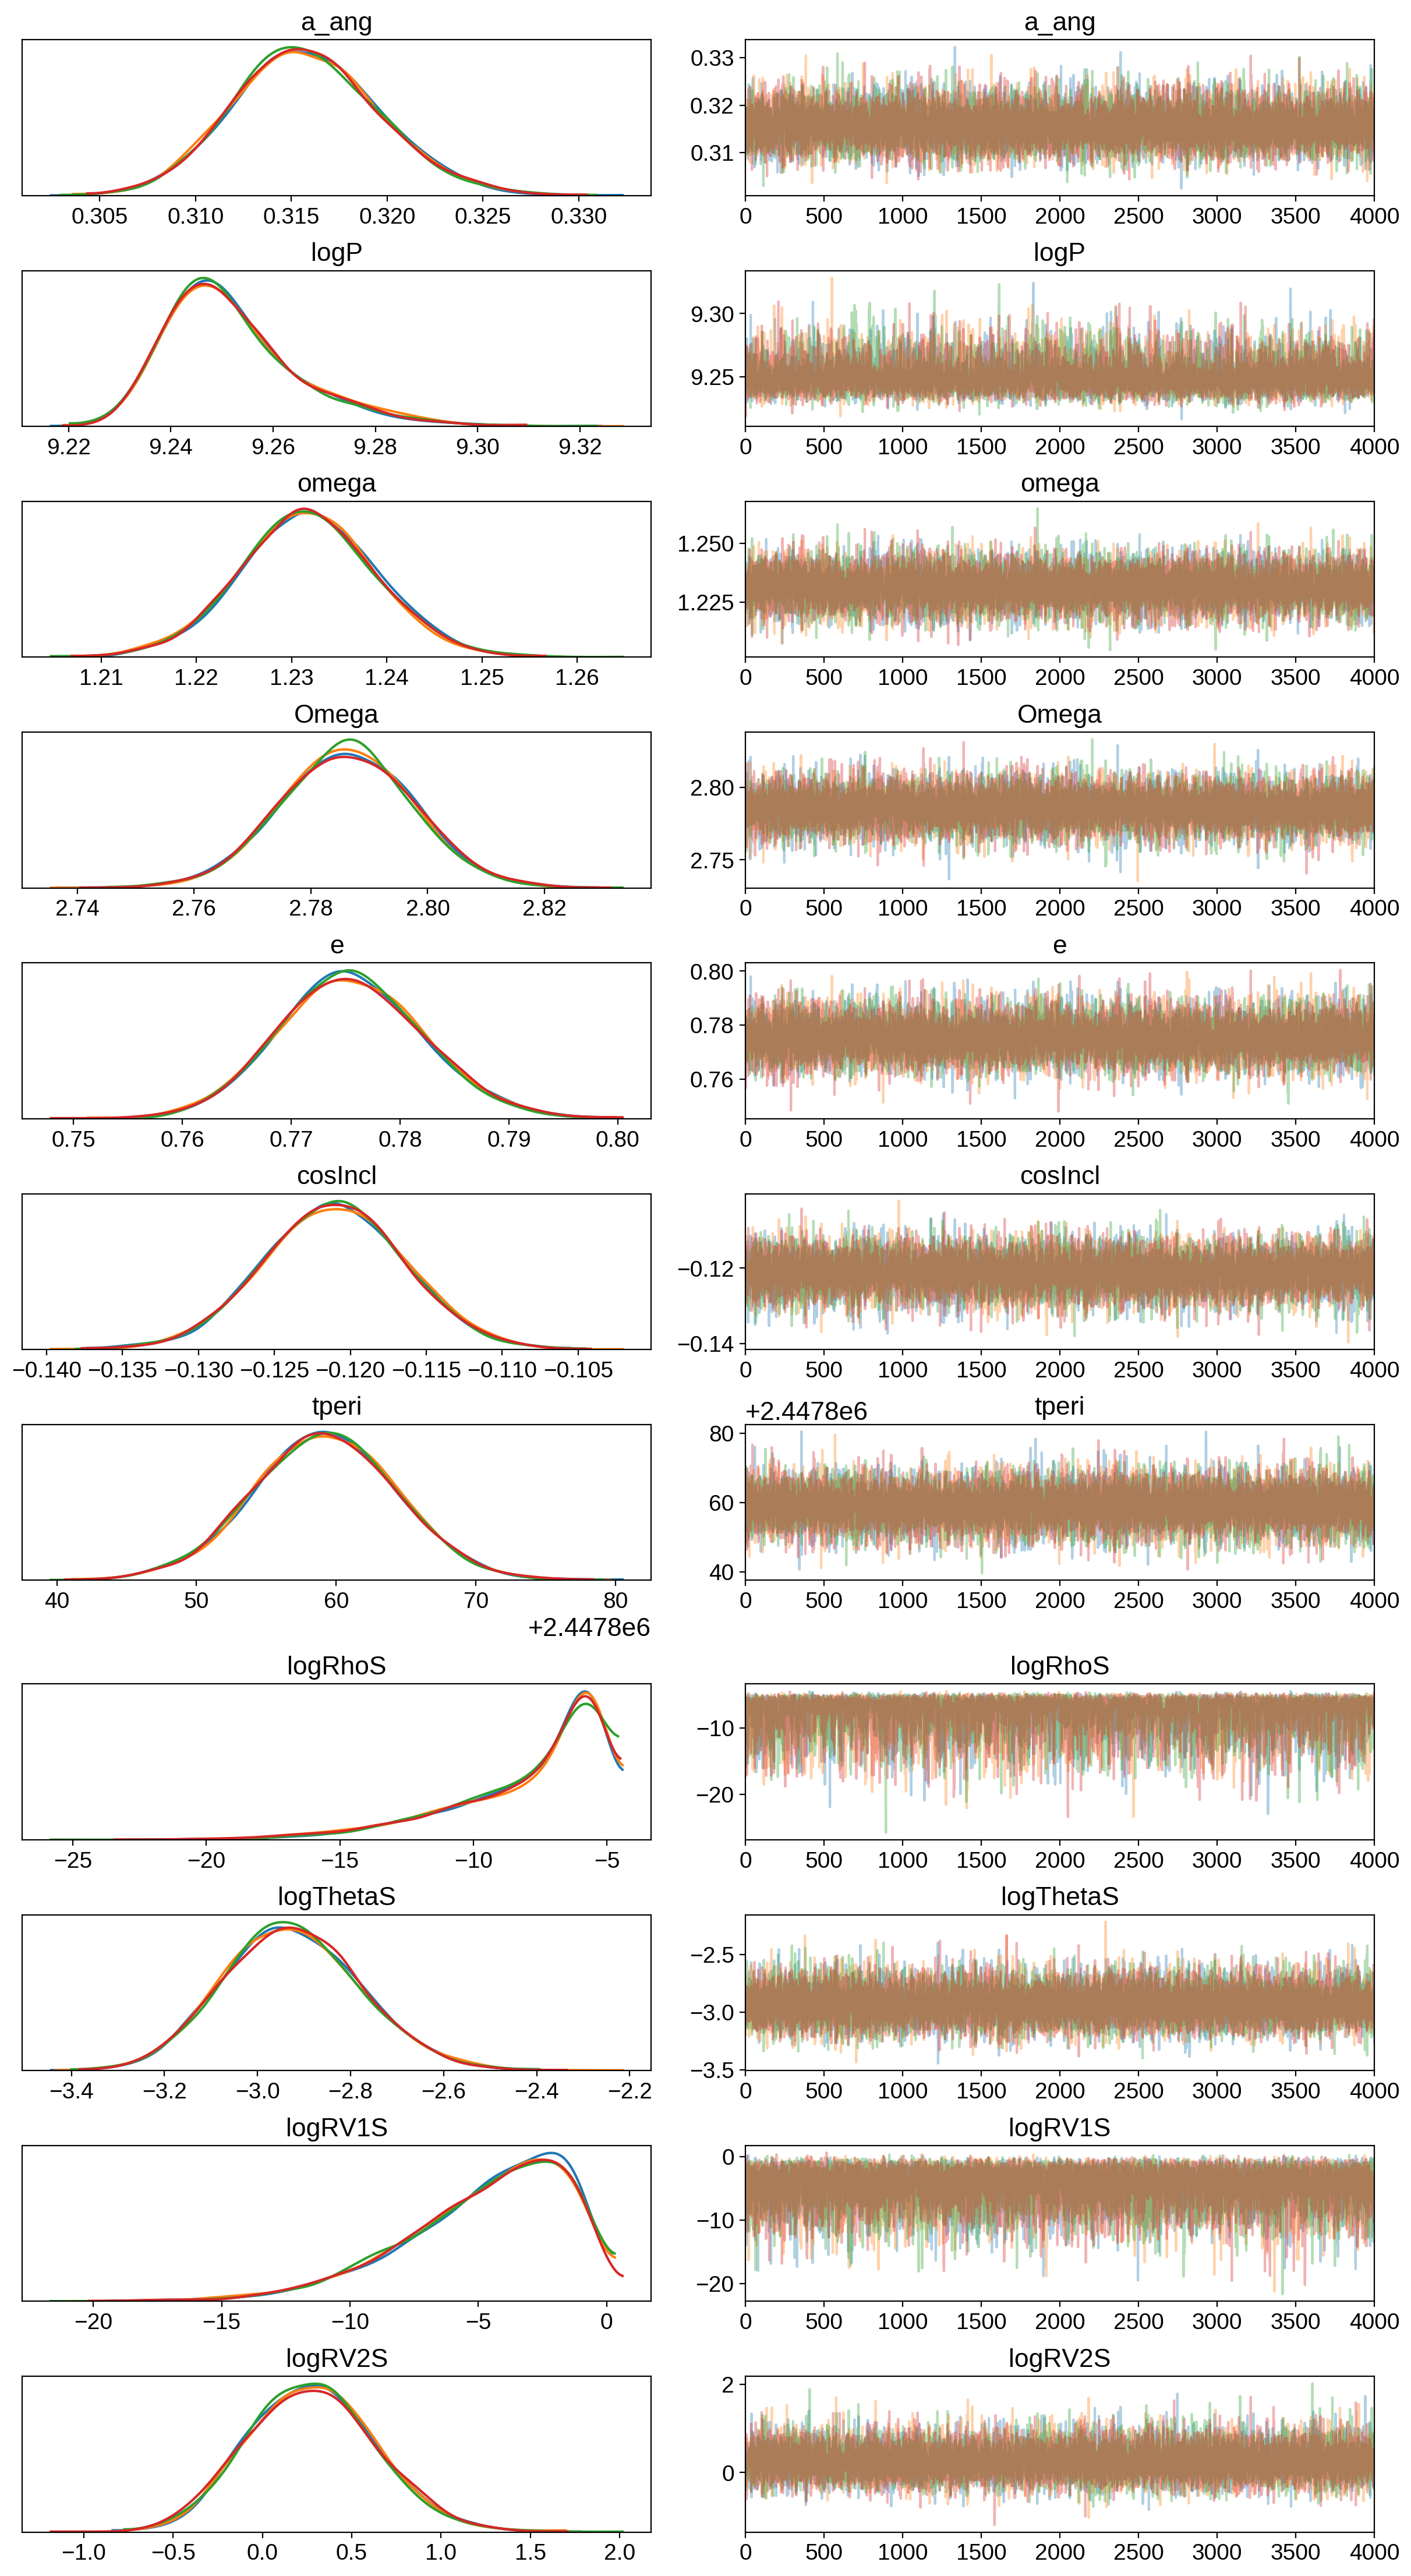

In [16]:
# let's examine the traces of the parameters we've sampled
pm.traceplot(trace, varnames=["a_ang", "logP", "omega", "Omega", "e", "cosIncl", "tperi", 
                              "logRhoS", "logThetaS", "logRV1S", "logRV2S"])

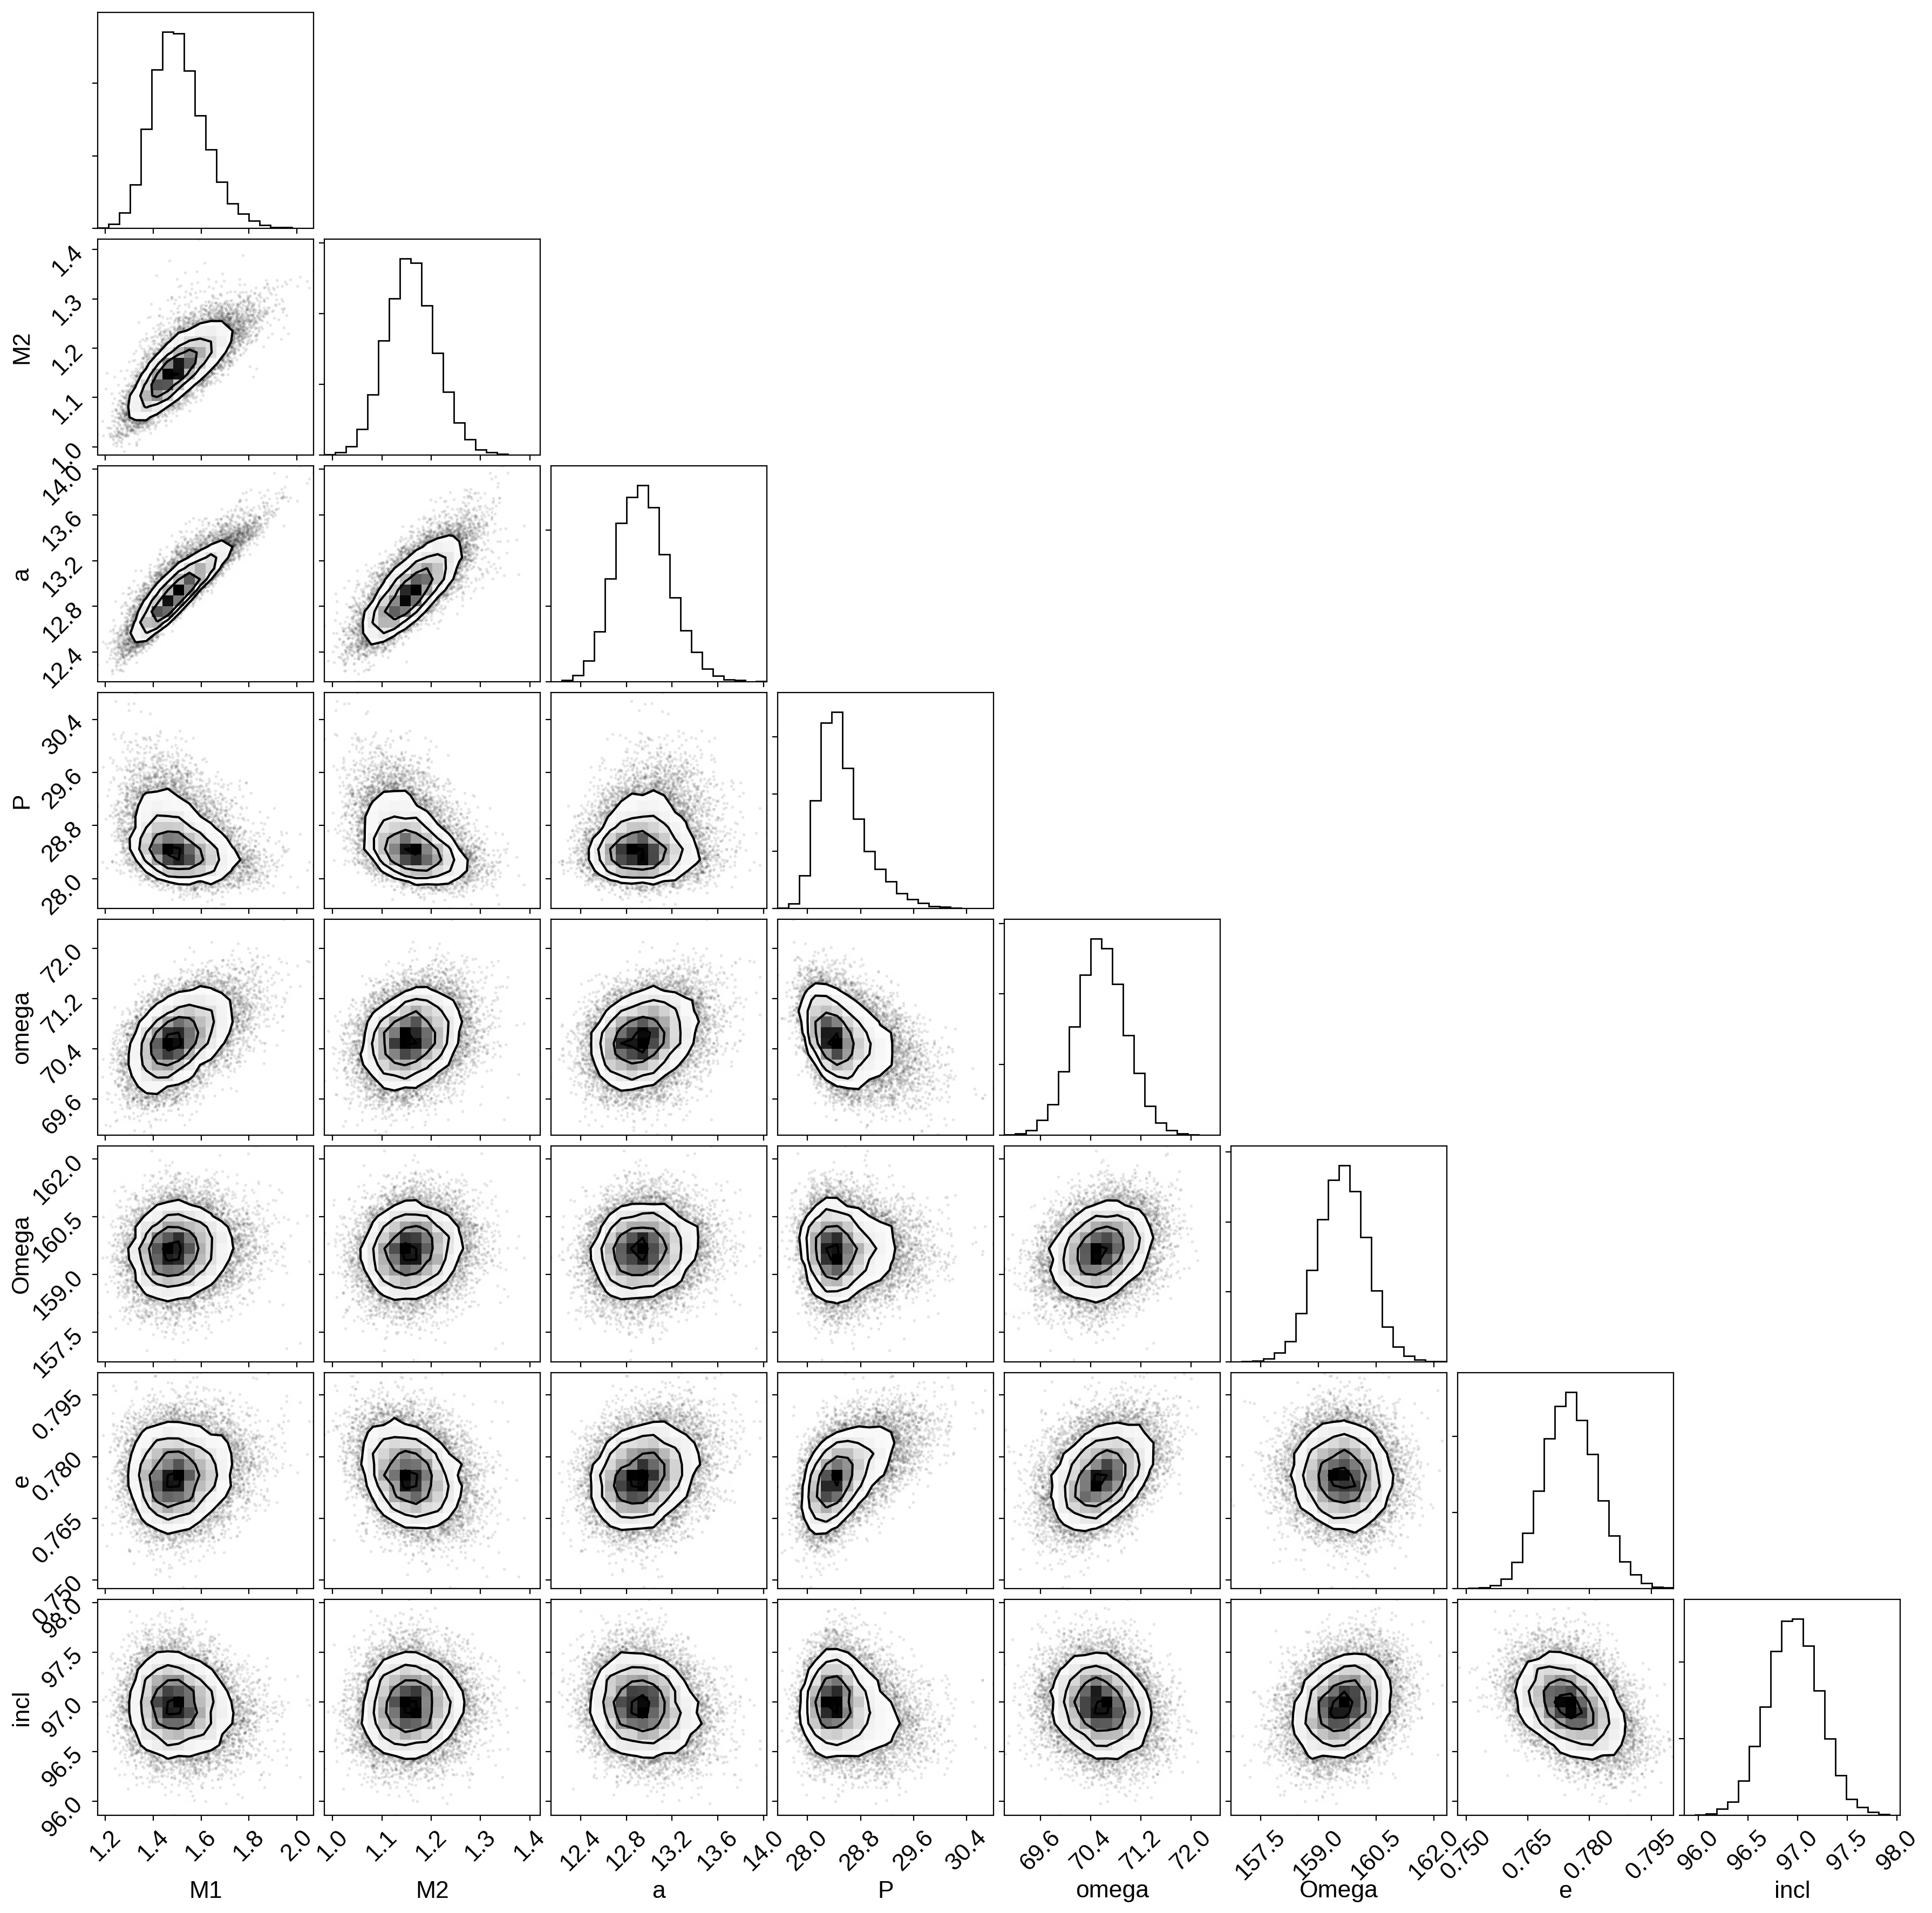

In [17]:
import corner  # https://corner.readthedocs.io

samples = pm.trace_to_dataframe(trace, varnames=["M1", "M2", "a", "P", "omega", "Omega", "e", "incl"])

samples["P"] /= yr
samples["incl"] /= deg
samples["omega"] /= deg
samples["Omega"] /= deg

corner.corner(samples);

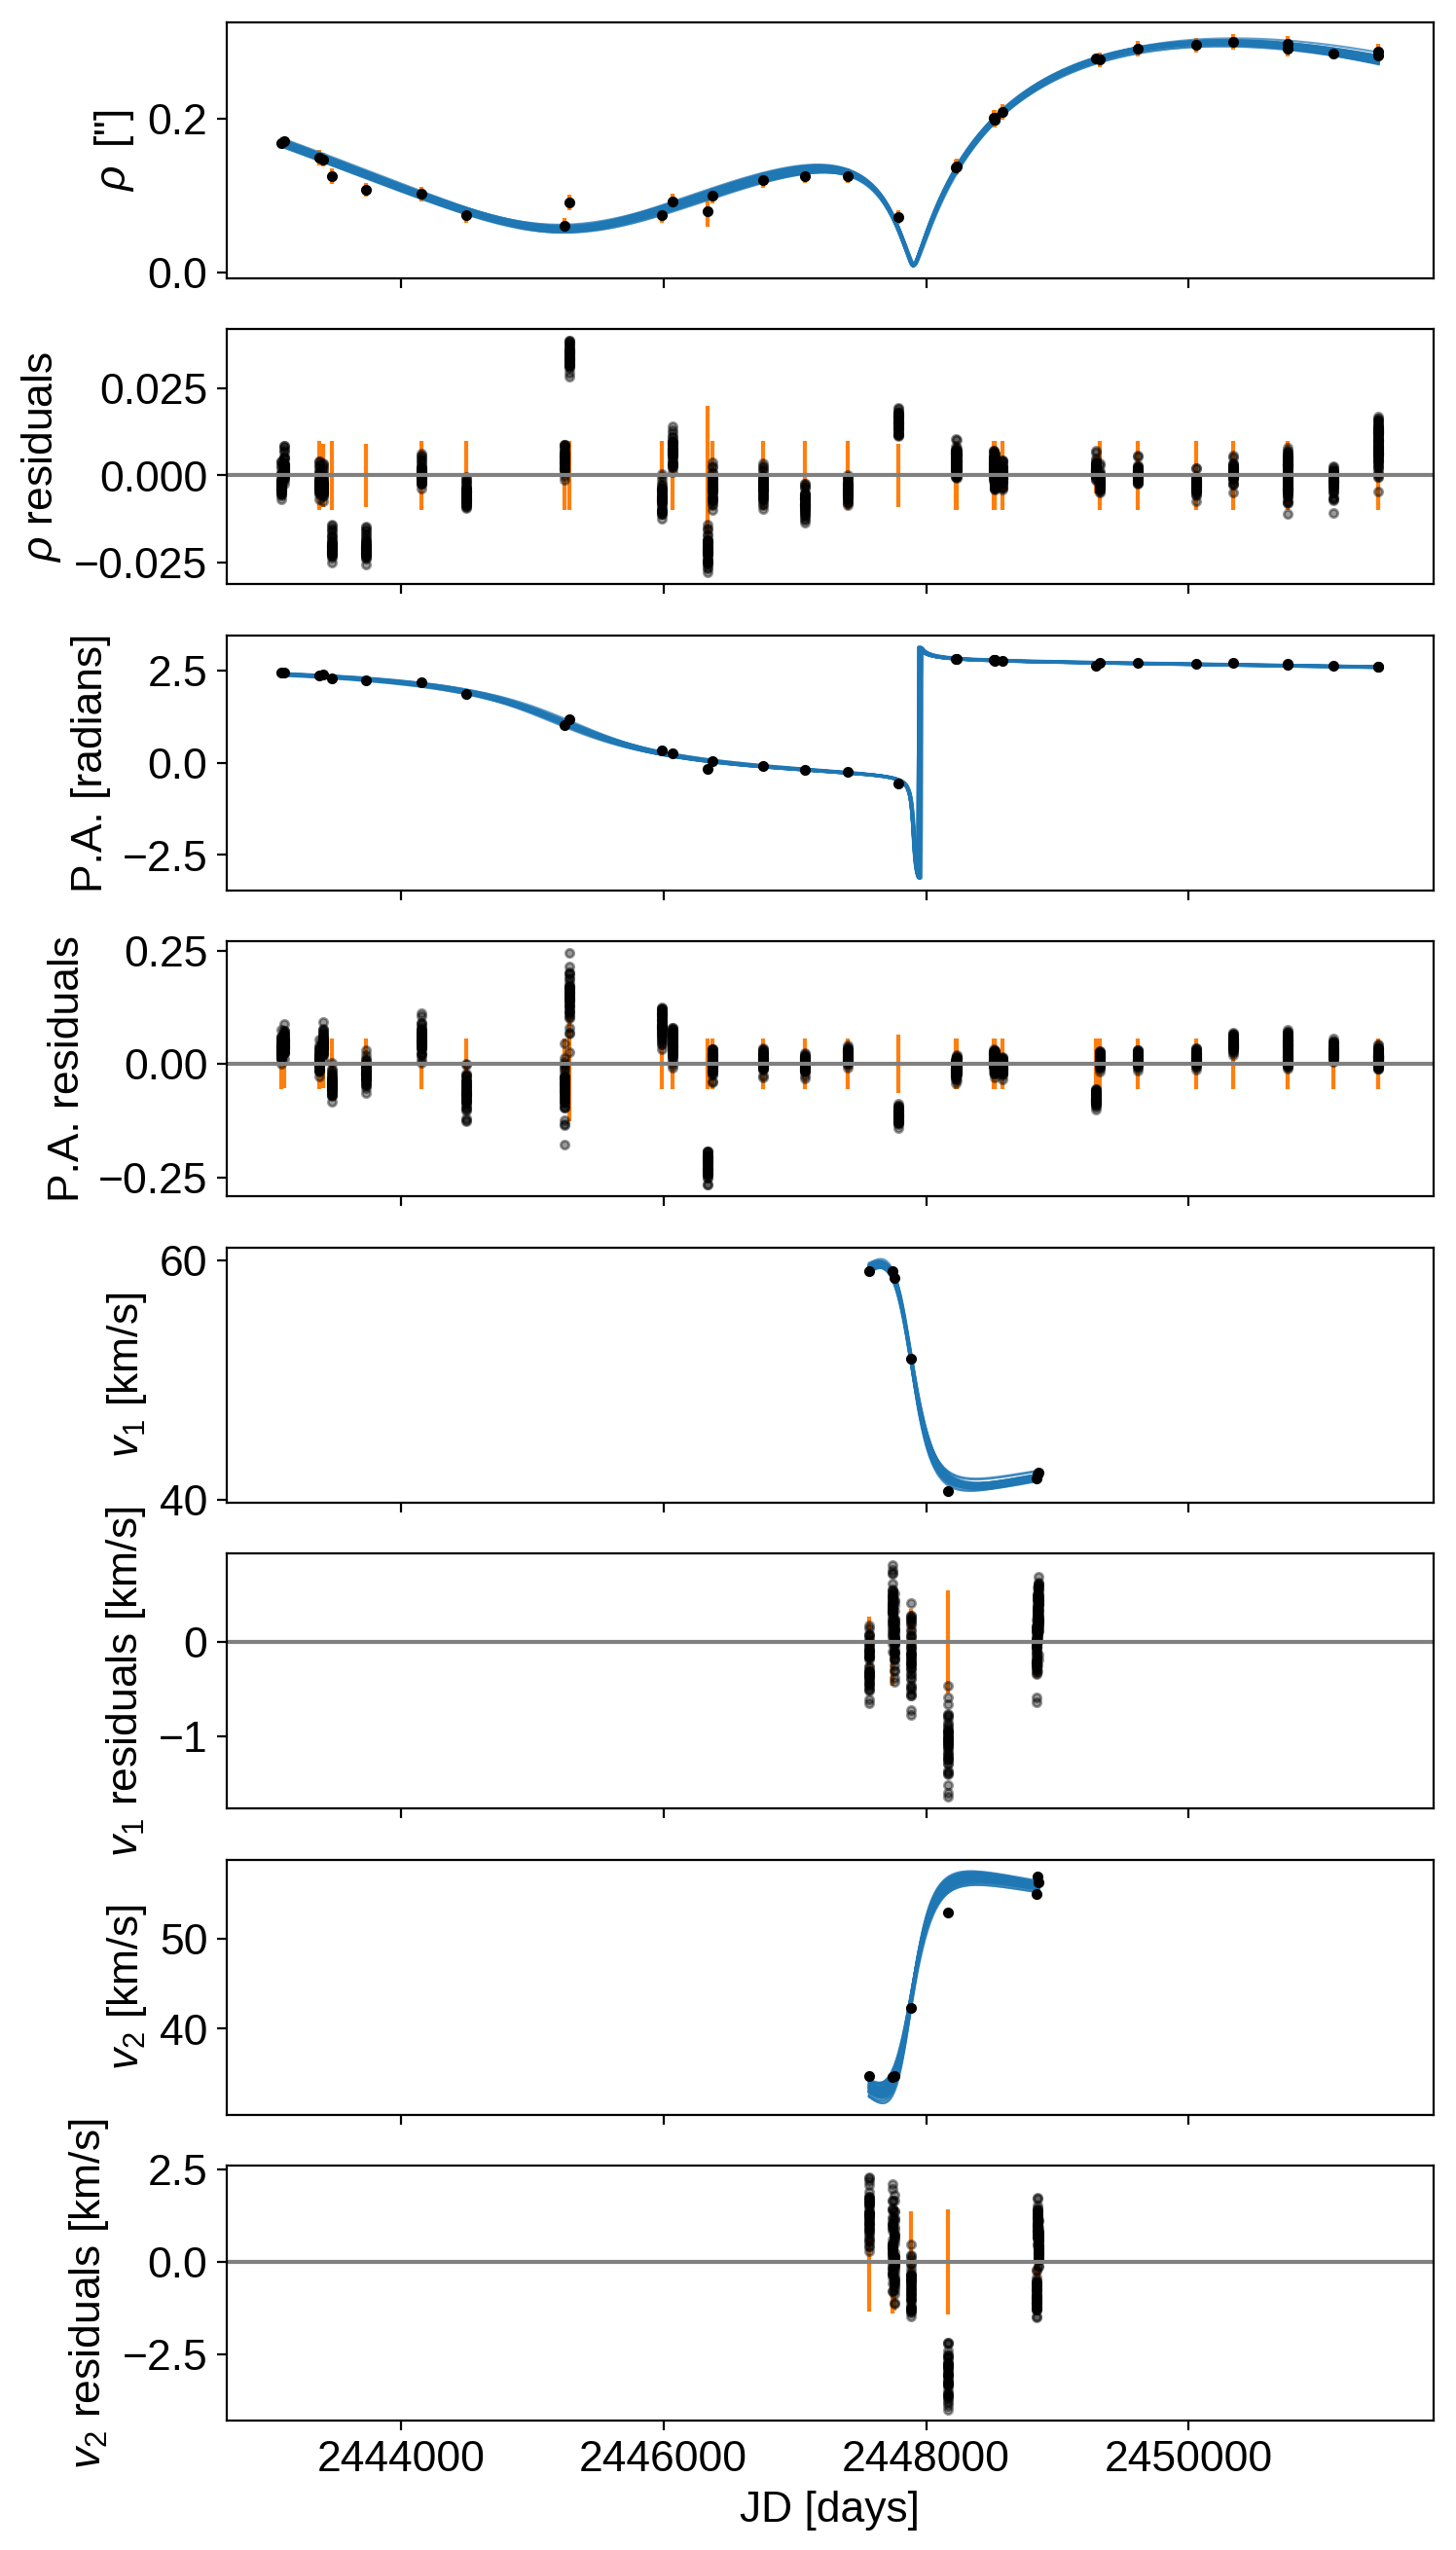

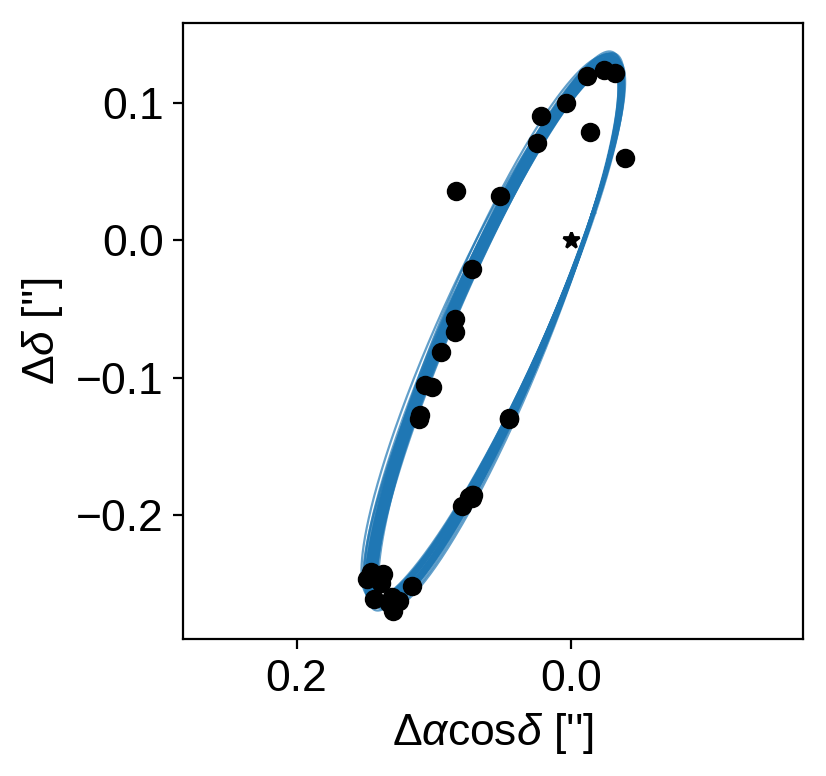

In [18]:
# plot the orbits on the figure

# we can plot the maximum posterior solution to see

pkw = {'marker':".", "color":"k", 'ls':""}
ekw = {'color':"C1", 'ls':""}

fig, ax = plt.subplots(nrows=8, sharex=True, figsize=(8,16))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

nsamples = 50
choices = np.random.choice(len(trace), size=nsamples)

# get map sol for tot_rho_err

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["logRhoS"])))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["logThetaS"])))

tot_rv1_err = np.sqrt(rv1_err**2 + np.exp(2 * np.median(trace["logRV1S"])))
tot_rv2_err = np.sqrt(rv2_err**2 + np.exp(2 * np.median(trace["logRV2S"])))
    

ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')
ax[4].set_ylabel(r'$v_1$ [km/s]')
ax[5].set_ylabel(r'$v_1$ residuals [km/s]')
ax[6].set_ylabel(r'$v_2$ [km/s]')
ax[7].set_ylabel(r'$v_2$ residuals [km/s]')
ax[7].set_xlabel("JD [days]")    


fig_sky, ax_sky = plt.subplots(nrows=1, figsize=(4,4))


with model:
    # iterate through trace object
    for i in choices:
        
        pos = trace[i] 
    
        rho_pred = pos["rhoSaveSky"]
        theta_pred = pos["thetaSaveSky"]

        x_pred = rho_pred * np.cos(theta_pred) # X north
        y_pred = rho_pred * np.sin(theta_pred) # Y east
    
        ax[0].plot(t_fine, pos["rhoSave"], color="C0", lw=0.8, alpha=0.7)
        
        ax[1].plot(astro_jds, rho_data - xo.eval_in_model(rho_model, pos), **pkw, alpha=0.4)

        ax[2].plot(t_fine, pos["thetaSave"], color="C0", lw=0.8, alpha=0.7)

        ax[3].plot(astro_jds, theta_data - xo.eval_in_model(theta_model, pos), **pkw, alpha=0.4)

        ax[4].plot(rv_times, pos["rv1Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[5].plot(rv1_jds, rv1 - xo.eval_in_model(rv1_model, pos), **pkw, alpha=0.4)
        
        ax[6].plot(rv_times, pos["rv2Save"], color="C0", lw=0.8, alpha=0.7)
        
        ax[7].plot(rv1_jds, rv2 - xo.eval_in_model(rv2_model, pos), **pkw, alpha=0.4)
        
        ax_sky.plot(y_pred, x_pred, color="C0", lw=0.8, alpha=0.7)
        
        

ax[0].plot(astro_jds, rho_data, **pkw)
ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
    
ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_rho_err, **ekw)

ax[2].plot(astro_jds, theta_data, **pkw)
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
    
ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, np.zeros_like(astro_jds), yerr=tot_theta_err, **ekw) 

ax[4].plot(rv1_jds, rv1, **pkw)

ax[5].axhline(0.0, color="0.5")
ax[5].errorbar(rv1_jds, np.zeros_like(rv1_jds), yerr=tot_rv1_err, **ekw)

ax[6].plot(rv2_jds, rv2, **pkw)

ax[7].axhline(0.0, color="0.5")
ax[7].errorbar(rv2_jds, np.zeros_like(rv2_jds), yerr=tot_rv2_err, **ekw)


xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax_sky.plot(ys, xs, "ko")
ax_sky.set_ylabel(r"$\Delta \delta$ ['']")
ax_sky.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax_sky.invert_xaxis()
ax_sky.plot(0,0, "k*")
ax_sky.set_aspect("equal", "datalim")